# PART I: Weather data processing

### This part of the code perform the following tasks:

- Read the CSV file containing weather data from 2013 to 2023 in Washington DC.
- Perform some basic manipulations on the data.
- Convert the resulting dataframe into a Spark dataframe.
- Finally, migrate the Spark dataframe into a MongoDB collection for future analysis.

## Import libraries

In [1]:
import time
from pprint import pprint
import pandas as pd
from datetime import datetime
import pymongo
import json
from kafka import KafkaConsumer
import os
import pytz
from pytz import timezone
from dateutil import tz
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pymongo import MongoClient
import requests
import folium
import branca.colormap as cm

## Import weather data from 2013 to 2023.

In [2]:
df = pd.read_csv('2d8242457dbe0baa13874aac40efb970.csv')

In [3]:
utc_timezone = pytz.utc
local_timezone = pytz.timezone('Europe/Rome')
df['dt_iso'] = df['dt_iso'].str[:-10]
df['dt_iso'] = pd.to_datetime(df['dt_iso'], format='%Y-%m-%d %H:%M:%S')
df['dt_iso'] = df['dt_iso'].dt.strftime('%Y-%m-%d %H:%M:%S')
df['dt_iso'] = pd.to_datetime(df['dt_iso'], format='%Y-%m-%d %H:%M:%S')

df['dt_iso'] = df['dt_iso'].apply(lambda x: x.tz_localize(utc_timezone).tz_convert(local_timezone).strftime('%Y-%m-%d %H:%M:%S'))
df['dt_iso'] = pd.to_datetime(df['dt_iso'])
# Crea un oggetto Timezone con il fuso orario di Washington DC
fuso_orario_dc = pytz.timezone('America/New_York')
# Crea un oggetto Timezone con il fuso orario locale (assumendo che sia il fuso orario corrente)
fuso_orario_locale = tz.tzlocal()
# Converti la colonna con la data locale al fuso orario di Washington DC, gestendo il cambio di orario
df['data_dc'] = df['dt_iso'].dt.tz_localize(fuso_orario_locale).dt.tz_convert(fuso_orario_dc)
df['date'] = df['data_dc'].dt.date
df['ora'] = df['data_dc'].dt.time
# Converti la colonna 'ora' in una stringa
df['ora'] = df['ora'].astype(str)
# Estrai le prime due cifre dall'ora nella colonna 'ora'
df['ora'] = df['ora'].str[:2]
# Elimina i duplicati basati sulle colonne 'data' e 'ora'
df = df.drop_duplicates(subset=['dt_iso'])
df['data_dc'] = df['data_dc'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))

#df['data_dc'] = df['data_dc'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))

colonne_desiderate = ['date', 'ora', 'data_dc', 'temp', 'pressure', 'feels_like', 'humidity', 'wind_speed',
                      'weather_main', 'weather_id', 'dew_point', 'visibility', 'rain_1h', 'rain_3h',
                      'snow_1h', 'snow_3h']

new_df = df.loc[:, colonne_desiderate]
# Rinomina la colonna "data_dc" in "dt_iso"
new_df = new_df.rename(columns={"data_dc": "dt_iso"})

new_df['date'] = pd.to_datetime(new_df['date'])
new_df['date'] = new_df['date'].dt.strftime('%Y-%m-%d')

In [4]:
new_df

,date,ora,dt_iso,temp,pressure,feels_like,humidity,wind_speed,weather_main,weather_id,dew_point,visibility,rain_1h,rain_3h,snow_1h,snow_3h
0,2013-01-01,00,2013-01-01 00:00:00,4.07,1017,1.71,56,2.60,Clouds,804,-3.46,10000.0,NaN,NaN,NaN,NaN
1,2013-01-01,01,2013-01-01 01:00:00,3.60,1016,0.75,69,3.10,Clouds,804,-1.37,10000.0,NaN,NaN,NaN,NaN
2,2013-01-01,02,2013-01-01 02:00:00,3.79,1016,0.98,59,3.10,Clouds,803,-3.08,10000.0,NaN,NaN,NaN,NaN
3,2013-01-01,03,2013-01-01 03:00:00,3.72,1016,2.43,59,1.54,Clouds,804,-3.14,10000.0,NaN,NaN,NaN,NaN
4,2013-01-01,04,2013-01-01 04:00:00,3.75,1016,0.93,60,3.10,Clouds,804,-2.91,10000.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94321,2023-03-31,19,2023-03-31 19:00:00,18.76,1013,18.00,50,11.32,Rain,500,8.13,10000.0,0.81,NaN,NaN,NaN
94322,2023-03-31,20,2023-03-31 20:00:00,16.85,1014,16.18,61,12.35,Rain,500,9.29,10000.0,0.81,NaN,NaN,NaN
94323,2023-03-31,21,2023-03-31 21:00:00,15.98,1013,15.49,71,6.71,Rain,500,10.73,NaN,0.47,NaN,NaN,NaN
94324,2023-03-31,22,2023-03-31 22:00:00,15.64,1012,15.22,75,5.66,Clouds,804,11.23,10000.0,NaN,NaN,NaN,NaN


## As an example, here is the daily average temperature in Washington DC over the last 10 years.

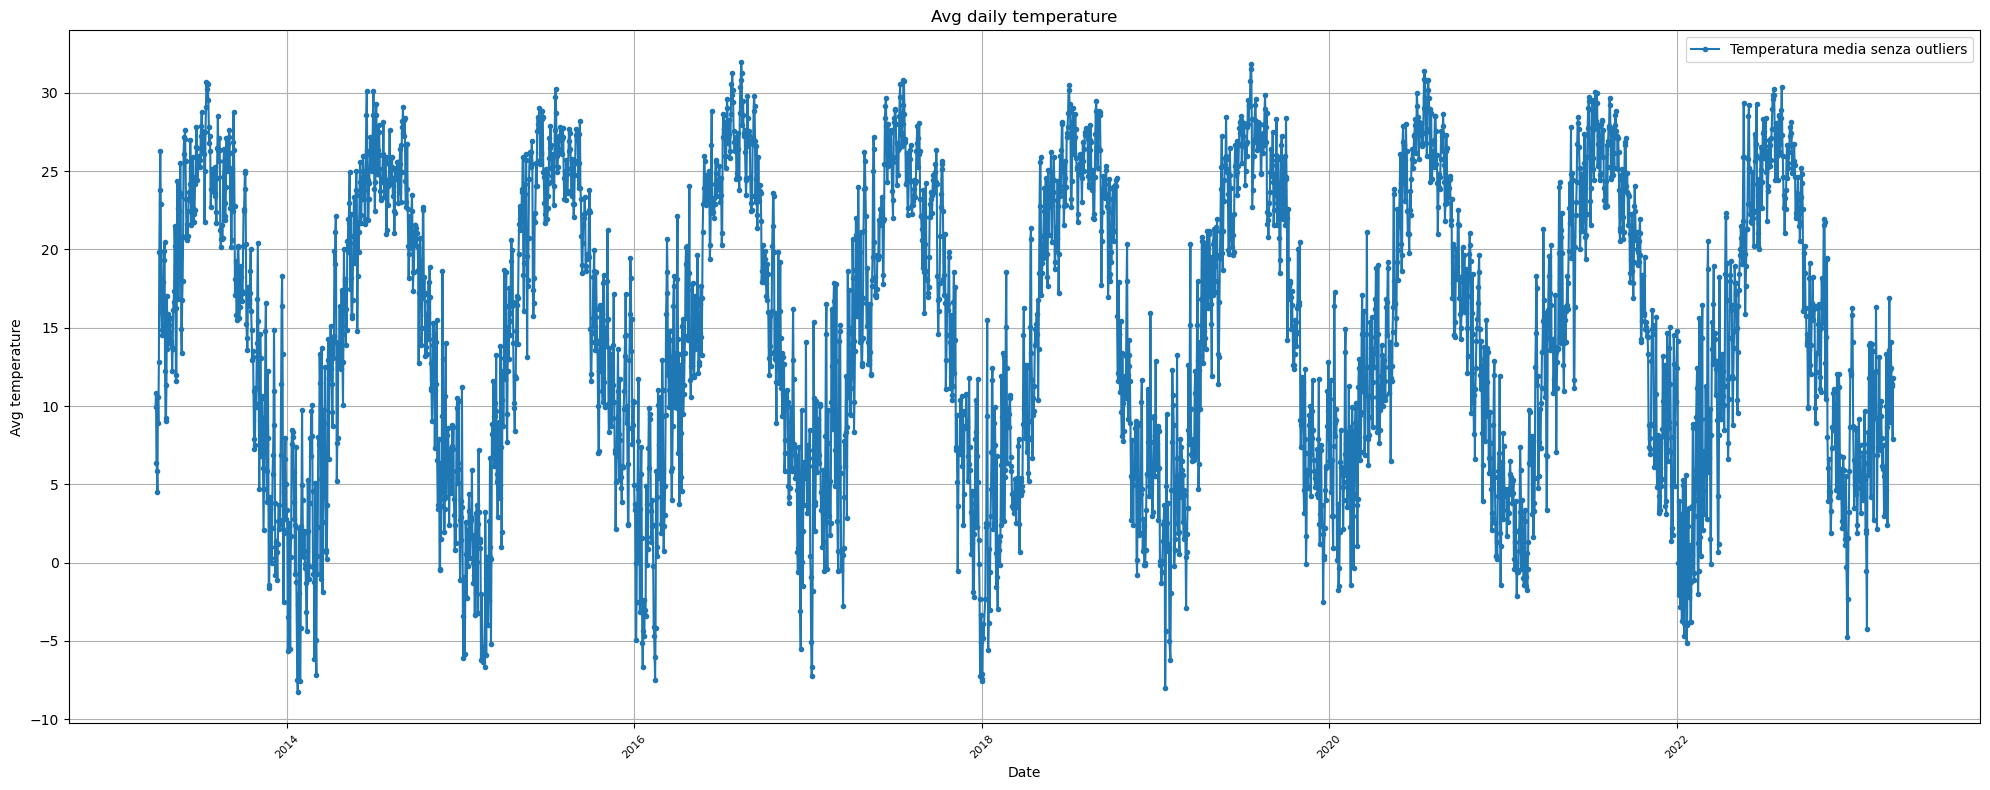

In [6]:
new_df['date'] = pd.to_datetime(new_df['date'])

media_temp_per_date = new_df.groupby('date')['temp'].mean()

data_max = media_temp_per_date.index.max()
inizio_ultimo_anno = data_max - pd.DateOffset(years=10)
ultimo_anno_dati = media_temp_per_date.loc[inizio_ultimo_anno:]

mean_temp = ultimo_anno_dati.mean()
std_temp = ultimo_anno_dati.std()
criterio = 2  
filtro = (ultimo_anno_dati >= mean_temp - criterio * std_temp) & (ultimo_anno_dati <= mean_temp + criterio * std_temp)
ultimo_anno_senza_outliers = ultimo_anno_dati[filtro]

plt.figure(figsize=(20, 8))
plt.plot(ultimo_anno_senza_outliers.index, ultimo_anno_senza_outliers, marker='.', linestyle='-', label='Temperatura media senza outliers')
plt.title('Avg daily temperature')
plt.xlabel('Date')
plt.ylabel('Avg temperature')
plt.xticks(rotation=45, fontsize=8)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Transform the Pandas DataFrame into a Spark DataFrame and insert it into a MongoDB collection.

**If you haven't already done so, open the terminal and type:**

docker run -d --name mongodb -p 27017:27017 mongo:latest

In [7]:
# MongoDB server connection
client = MongoClient("mongodb://localhost:27017/weather_data.weather_history")

# Spark configuration
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local') \
    .appName('myAppName') \
    .config('spark.mongodb.input.uri', 'mongodb://localhost:27017/weather_data.weather_history') \
    .config('spark.mongodb.output.uri', 'mongodb://localhost:27017/weather_data.weather_history') \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1') \
    .getOrCreate()


spark_df = spark.createDataFrame(new_df)

#3 insert the dataframe into a MongoDB collection.

spark_df.write.format("mongo").mode("overwrite").save()

spark.stop()  # Arresta la sessione Spark corrente


24/03/08 17:08:20 WARN Utils: Your hostname, MacBook-Pro-di-Giuseppe.local resolves to a loopback address: 127.0.0.1; using 192.168.200.186 instead (on interface en0)
24/03/08 17:08:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/Users/panda/mambaforge/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/panda/.ivy2/cache
The jars for the packages stored in: /Users/panda/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-6cfbb219-f184-477f-9ed9-1b2d5b983e4c;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
:: resolution report :: resolve 344ms :: artifacts dl 14ms
	:: modules in use:
	org.mongodb#bson;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-core;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-sync;4.0.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts

In [8]:
# Spark DataFrame schema
#spark_df.printSchema()


# PART II: Trip data processing

### This part of the code perform the following tasks:

- Read several CSV files containing trip data from 2013 to 2023 in Washington DC.
- Perform some basic manipulations on the data.
- Show the top 100 stations for departures on a leaflet map.
- Create an hourly aggregated dataframe.
- Convert the resulting dataframe into a Spark dataframe.
- Finally, migrate the Spark dataframe into a MongoDB collection for future analysis.

## Processing 2013-2017 trip data

In [7]:
try:
    print("Inizio del processo...")

    # Creazione della cartella se non esiste
    if not os.path.exists('TRIP_DATA_MOD'):
        os.makedirs('TRIP_DATA_MOD')

    # Definizione dei percorsi e dei file
    base_path = "TRIP_DATA"
    years = range(2013, 2018)
    quarters = ['Q1', 'Q2', 'Q3', 'Q4']
    files = [f"{base_path}/{year}{quarter}-capitalbikeshare-tripdata.csv" for year in years for quarter in quarters]

    # Lettura del primo file per ottenere le stazioni di partenza uniche
    start_stations = pd.read_csv(files[0])['Start station number'].unique().tolist()
    with open('start_stations.txt', 'w') as f:
        f.writelines(f"{station}\n" for station in start_stations)

    # Lettura e filtraggio dei file in un unico DataFrame
    dfs = [pd.read_csv(file) for file in files]
    merged_df = pd.concat(dfs, ignore_index=True).query('`Start station number` in @start_stations and `Member type` == "Member"')

    # Rinomina delle colonne e conversione del formato data
    merged_df = merged_df.rename(columns={'Start date': 'timestamp', 'Start station number': 'start_station_id'})
    merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])
    merged_df['date'] = merged_df['timestamp'].dt.date
    merged_df['ora'] = merged_df['timestamp'].dt.hour

    # Scrittura del DataFrame finale
    merged_df.to_csv('TRIP_DATA_MOD/DEF2013-2017.csv', index=False)
    print("Processo completato con successo!")

except Exception as e:
    print(f"Si è verificato un errore durante l'esecuzione del processo: {e}")


Inizio del processo...
Processo completato con successo!


## Processing 2018-2020 trip data

In [10]:
try:
    print("Inizio del processo...")
    
    # Carica le stazioni di partenza dal primo file
    start_stations = pd.read_csv("TRIP_DATA/2013Q1-capitalbikeshare-tripdata.csv")['Start station number'].unique().tolist()

    # Definisci gli anni e i mesi per i nomi dei file
    periods = [
        *[(2018, month) for month in range(1, 13)],  # 2018
        *[(2019, month) for month in range(1, 13)],  # 2019
        *[(2020, month) for month in range(1, 4)]    # 2020 fino a marzo
    ]

    # Genera i nomi dei file e leggi i dati
    dfs = [pd.read_csv(f"TRIP_DATA/{year}{month:02d}-capitalbikeshare-tripdata.csv") for year, month in periods]

    # Unisci tutti i DataFrame
    merged_df = pd.concat(dfs, ignore_index=True)

    # Filtra per le stazioni di partenza e per i membri
    filtered_df = merged_df[merged_df['Start station number'].isin(start_stations) & (merged_df['Member type'] == 'Member')]

    # Rinomina colonne e trasforma la colonna timestamp
    filtered_df = filtered_df.rename(columns={'Start date': 'timestamp', 'Start station number': 'start_station_id'})
    filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'])
    filtered_df['date'] = filtered_df['timestamp'].dt.date
    filtered_df['ora'] = filtered_df['timestamp'].dt.hour

    # Crea la cartella di destinazione se non esiste
    if not os.path.exists('TRIP_DATA_MOD'):
        os.makedirs('TRIP_DATA_MOD')

    # Scrivi il DataFrame finale
    filtered_df.to_csv('TRIP_DATA_MOD/DEF2018-2020.csv', index=False)
    
    print("Processo completato con successo!")

except Exception as e:
    print(f"Si è verificato un errore durante l'esecuzione del processo: {e}")


Inizio del processo...
Processo completato con successo!


## Processing 2020-2023 trip data

In [11]:
try:
    print("Inizio del processo...")

    # Carica le stazioni di partenza dal primo file
    start_stations = pd.read_csv("TRIP_DATA/2013Q1-capitalbikeshare-tripdata.csv")['Start station number'].unique().tolist()

    # Definisci gli anni e i mesi per i nomi dei file
    years_months = [
        (year, month) for year in range(2020, 2024) 
        for month in range(1, 13) if not (year == 2023 and month > 5)  # Fino a maggio 2023
    ]

    # Leggi i dati da tutti i file
    file_template = "TRIP_DATA/{:04d}{:02d}-capitalbikeshare-tripdata.csv"
    dfs = [pd.read_csv(file_template.format(year, month)) for year, month in years_months]

    # Unisci tutti i DataFrame
    merged_df = pd.concat(dfs, ignore_index=True)

    # Filtra le righe basandosi su stazioni di partenza e tipo di membro
    filtered_df = merged_df[merged_df['start_station_id'].isin(start_stations) & (merged_df['member_casual'] == 'member')]

    # Rinomina colonne e converti la colonna timestamp
    filtered_df = filtered_df.rename(columns={'started_at': 'timestamp'})
    filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'])
    filtered_df['date'] = filtered_df['timestamp'].dt.date
    filtered_df['ora'] = filtered_df['timestamp'].dt.hour

    # Assicurati che la cartella di destinazione esista
    os.makedirs('TRIP_DATA_MOD', exist_ok=True)

    # Scrivi il DataFrame finale
    filtered_df.to_csv('TRIP_DATA_MOD/DEF2020-2023.csv', index=False)
    
    print("Processo completato con successo!")

except Exception as e:
    print(f"Si è verificato un errore durante l'esecuzione del processo: {e}")


Inizio del processo...


/var/folders/09/9c49925d64jdq04kbs3b7w_00000gn/T/ipykernel_15294/4263062928.py:15: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(file_template.format(year, month)) for year, month in years_months]


Processo completato con successo!


## Merging the processed trip data (it may take a while)

In [9]:
df1=pd.read_csv('TRIP_DATA_MOD/DEF2018-2020.csv')
df2=pd.read_csv('TRIP_DATA_MOD/DEF2020-2023.csv')

# Unisci i due DataFrame verticalmente
merged_df = pd.concat([df1, df2], ignore_index=True)
merged_df.to_csv('TRIP_DATA_MOD/DEF2018-2023.csv')

In [10]:
df1=pd.read_csv('TRIP_DATA_MOD/DEF2013-2017.csv') 
df2=pd.read_csv('TRIP_DATA_MOD/DEF2018-2023.csv')

df_full=pd.concat([df1, df2], ignore_index=True)
df_full.to_csv('TRIP_DATA_MOD/DEF2018-2023_full.csv', index=False)

/var/folders/09/9c49925d64jdq04kbs3b7w_00000gn/T/ipykernel_28166/3924144071.py:2: DtypeWarning: Columns (3,5,7,8,9,14,15,16,17,18,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df2=pd.read_csv('TRIP_DATA_MOD/DEF2018-2023.csv')


In [11]:
df_full.head()

,Duration,timestamp,End date,start_station_id,Start station,End station number,End station,Bike number,Member type,date,...,rideable_type,ended_at,start_station_name,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,688.0,2013-01-01 00:03:55,2013-01-01 00:15:24,31101.0,14th & V St NW,31106.0,Calvert & Biltmore St NW,W01210,Member,2013-01-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,699.0,2013-01-01 00:04:39,2013-01-01 00:16:19,31236.0,37th & O St NW / Georgetown University,31304.0,36th & Calvert St NW / Glover Park,W01075,Member,2013-01-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,365.0,2013-01-01 00:10:01,2013-01-01 00:16:06,31257.0,22nd & I St NW / Foggy Bottom,31239.0,Rhode Island & Connecticut Ave NW,w00527,Member,2013-01-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,292.0,2013-01-01 00:12:55,2013-01-01 00:17:47,31614.0,11th & H St NE,31612.0,D St & Maryland Ave NE,W00040,Member,2013-01-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,222.0,2013-01-01 00:13:24,2013-01-01 00:17:07,31239.0,Rhode Island & Connecticut Ave NW,31214.0,17th & Corcoran St NW,W20891,Member,2013-01-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Showing stations and departures 

In [73]:
df=df_full.copy()

In [74]:
# 1. Conta le partenze per ogni stazione e ottieni le top 100
top_stations = df['start_station_name'].value_counts().head(100)

# 2. Ottenere le coordinate per le top 50 stazioni
coordinates = df.drop_duplicates(subset=['start_station_name'])[['start_station_name', 'start_lat', 'start_lng']]

# Filtro per mantenere solo le top 50 stazioni
top_stations_coordinates = coordinates[coordinates['start_station_name'].isin(top_stations.index)]

# 3. Creare una mappa Folium
map_center = [top_stations_coordinates['start_lat'].mean(), top_stations_coordinates['start_lng'].mean()]
mappa = folium.Map(location=map_center, zoom_start=13)

# Usa 'CartoDB Positron' per una mappa più chiara
#folium.TileLayer('CartoDB positron').add_to(mappa)

# Calcolare un raggio dinamico per ogni cerchio basato sul numero di partenze
# Stabilire un raggio minimo e massimo
raggio_min = 5
raggio_max = 15
num_min = top_stations.min()
num_max = top_stations.max()

# Funzione per calcolare il raggio in base al numero di partenze
def calcola_raggio(n):
    return raggio_min + (n - num_min) / (num_max - num_min) * (raggio_max - raggio_min)

# Aggiungere cerchi per ogni stazione con raggio basato sul numero di partenze
for _, row in top_stations_coordinates.iterrows():
    folium.CircleMarker(
        location=[row['start_lat'], row['start_lng']],
        radius=calcola_raggio(top_stations[row['start_station_name']]),  # Usa il raggio calcolato
        popup=f"{row['start_station_name']}: {top_stations[row['start_station_name']]} partenze",
        color='blue',
        fillColor='blue',
        fill=True,
        fillOpacity=0.5
    ).add_to(mappa)

folium.LayerControl().add_to(mappa)

# Mostrare la mappa
mappa


## Showing top stations by number of departures

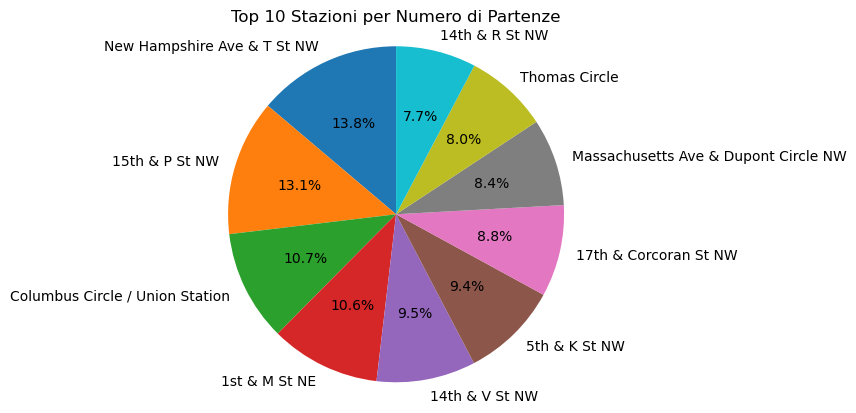

In [75]:
# Calcolare le top 10 stazioni per numero di partenze
top_10_stations = df['start_station_name'].value_counts().head(10)

# Creare il grafico a torta
fig, ax = plt.subplots()
ax.pie(top_10_stations, labels=top_10_stations.index, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Aggiungere un titolo
plt.title('Top 10 Stazioni per Numero di Partenze')

# Mostrare il grafico
plt.show()


# PART III: We choose Thomas Circle as our target station

In [78]:
'''# Trova lo station_id per la stazione "New Hampshire Ave & T St NW"
station_id = df[df['start_station_name'] == "New Hampshire Ave & T St NW"]['start_station_id'].unique()[0]

print(station_id)'''

'# Trova lo station_id per la stazione "New Hampshire Ave & T St NW"\nstation_id = df[df[\'start_station_name\'] == "New Hampshire Ave & T St NW"][\'start_station_id\'].unique()[0]\n\nprint(station_id)'

In [77]:
# Trova lo station_id per la stazione "New Hampshire Ave & T St NW"
station_id = df[df['start_station_name'] == "Thomas Circle"]['start_station_id'].unique()[0]

print(station_id)

31241.0


In [79]:
# Filtra df_full per la stazione con station_id 31229.0
#filtered_df = df_full[df_full['start_station_id'] == 31229.0]
filtered_df = df_full[df_full['start_station_id'] == 31241.0]

In [80]:
filtered_df.tail()

,Duration,timestamp,End date,start_station_id,Start station,End station number,End station,Bike number,Member type,date,...,rideable_type,ended_at,start_station_name,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
15692207,NaN,2023-05-10 07:13:36,NaN,31241.0,NaN,NaN,NaN,NaN,NaN,2023-05-10,...,classic_bike,2023-05-10 07:20:55,Thomas Circle,14th & L St NW,31283.0,38.905900,-77.032500,38.903658,-77.031737,member
15692208,NaN,2023-05-05 13:22:01,NaN,31241.0,NaN,NaN,NaN,NaN,NaN,2023-05-05,...,electric_bike,2023-05-05 13:39:21,Thomas Circle,M St & New Jersey Ave SE,31208.0,38.905826,-77.032556,38.876300,-77.003700,member
15692213,NaN,2023-05-05 07:43:11,NaN,31241.0,NaN,NaN,NaN,NaN,NaN,2023-05-05,...,classic_bike,2023-05-05 08:05:18,Thomas Circle,19th St N & Ft Myer Dr,31014.0,38.905900,-77.032500,38.897218,-77.072143,member
15692384,NaN,2023-05-03 07:03:20,NaN,31241.0,NaN,NaN,NaN,NaN,NaN,2023-05-03,...,classic_bike,2023-05-03 07:05:13,Thomas Circle,14th & L St NW,31283.0,38.905900,-77.032500,38.903658,-77.031737,member
15692385,NaN,2023-05-22 07:42:06,NaN,31241.0,NaN,NaN,NaN,NaN,NaN,2023-05-22,...,electric_bike,2023-05-22 08:00:57,Thomas Circle,M St & New Jersey Ave SE,31208.0,38.905881,-77.032585,38.876300,-77.003700,member


In [81]:
filtered_df.shape

(254436, 25)

## Creating a hourly aggregated dataframe for New Hampshire station

In [82]:
counts = filtered_df.groupby(['date', 'ora']).size().reset_index(name='cnt')
merged_df=counts
merged_df.to_csv('TRIP_DATA_MOD/DEF2013-2023.csv',index=False)

In [83]:
merged_df.head()

,date,ora,cnt
0,2013-01-01,1,2
1,2013-01-01,2,1
2,2013-01-01,9,1
3,2013-01-01,11,1
4,2013-01-01,12,3


## Migrate the hourly aggregate dataframe into a Mongodb collection called sales_history

In [84]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pymongo import MongoClient

# Connessione al server MongoDB
client = MongoClient("mongodb://localhost:27017/")

# Configurazione Spark
spark = SparkSession.builder \
    .master('local') \
    .config('spark.mongodb.input.uri', 'mongodb://localhost:27017/sales_data.sales_history') \
    .config('spark.mongodb.output.uri', 'mongodb://localhost:27017/sales_data.sales_history') \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1') \
    .getOrCreate()

df = spark.read.csv("TRIP_DATA_MOD/DEF2013-2023.csv", header=True)

# Scrittura del DataFrame in MongoDB
df.write.format("mongo").mode("append").save()

# Verifica dei documenti inseriti
db = client['sales_data']
collection = db['sales_history']
documents = collection.find({})

spark.stop()  # Arresta la sessione Spark corrente

24/03/08 17:37:26 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# PART IV : Integrate Weather data with trip data

In [85]:
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
import os


from pyspark.sql.functions import col

# Configurazione Spark per la prima collection
spark1 = SparkSession.builder \
    .appName("MongoDB1 to DataFrame") \
    .config('spark.mongodb.input.uri', 'mongodb://localhost:27017/sales_data.sales_history') \
    .config('spark.mongodb.output.uri', 'mongodb://localhost:27017/sales_data.sales_history') \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1') \
    .getOrCreate()

df1 = spark1.read.format("com.mongodb.spark.sql.DefaultSource") \
    .option("uri", "mongodb://localhost:27017/sales_data.sales_history") \
    .load()
df1 = df1.select([col(c).cast("string") for c in df1.columns])

# Configurazione Spark per la seconda collection
spark2 = SparkSession.builder \
    .appName("MongoDB2 to DataFrame") \
    .config('spark.mongodb.input.uri', 'mongodb://localhost:27017/weather_data.weather_history') \
    .config('spark.mongodb.output.uri', 'mongodb://localhost:27017/weather_data.weather_history') \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1') \
    .getOrCreate()

df2 = spark2.read.format("com.mongodb.spark.sql.DefaultSource") \
    .option("uri", "mongodb://localhost:27017/weather_data.weather_history") \
    .load()
df2 = df2.select([col(c2).cast("string") for c2 in df2.columns])

24/03/08 17:37:43 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [86]:
df1.head()

Row(_id='{65eb3a7aecab5117c42e262c}', cnt='3', date='2013-01-01', ora='1')

In [87]:
df2.head()

Row(_id='{65eb3810ecab5117c42cc766}', date='2013-01-01 00:00:00', dew_point='-3.46', dt_iso='2013-01-01 00:00:00', feels_like='1.71', humidity='56', ora='00', pressure='1017', rain_1h='NaN', rain_3h='NaN', snow_1h='NaN', snow_3h='NaN', temp='4.07', visibility='10000.0', weather_id='804', weather_main='Clouds', wind_speed='2.6')

In [88]:
# Converti i DataFrame Spark in DataFrame Pandas
df1_pandas = df1.toPandas()
df2_pandas = df2.toPandas()

# Droppare le colonne '_id' dai DataFrame Pandas
df1_pandas = df1_pandas.drop('_id', axis=1)
df2_pandas = df2_pandas.drop('_id', axis=1)

df1=df1_pandas.copy()
df2=df2_pandas.copy()

In [89]:
df2['ora'] = df2['ora'].apply(lambda x: '0' if x == '00' else x.lstrip('0'))

In [90]:
# Estrai solamente la data, senza l'ora
df2['date'] = pd.to_datetime(df2['date'])
df2['date'] = df2['date'].dt.date

In [91]:
# Converti le colonne 'date' e 'ora' in stringhe in df1
df1['date'] = df1['date'].astype(str)
df1['ora'] = df1['ora'].astype(str)

# Converti le colonne 'date' e 'ora' in stringhe in df2
df2['date'] = df2['date'].astype(str)
df2['ora'] = df2['ora'].astype(str)

# Ora puoi procedere con il merge
merged_df = pd.merge(df1, df2, on=['date', 'ora'], how='inner')


In [92]:
df1=df1_pandas.copy()

df2=df2_pandas.copy()

df=pd.read_csv('TRIP_DATA_MOD/DEF2013-2023.csv')

df['date'] = pd.to_datetime(df['date'])

In [93]:
import numpy as np

# sostituiamo i valori nulli con 0 nelle colonne 'rain_1h', 'rain_3h', 'snow_1h' e 'snow_3h'
merged_df['rain_1h'] = merged_df['rain_1h'].replace("NaN", 0)
merged_df['rain_3h'] = merged_df['rain_3h'].replace("NaN", 0)
merged_df['snow_1h'] = merged_df['snow_1h'].replace("NaN", 0)
merged_df['snow_3h'] = merged_df['snow_3h'].replace("NaN", 0)
merged_df['visibility'] = merged_df['visibility'].replace("NaN", 0)


# selezioniamo l'ordine desiderato delle colonne
#new_columns = ['dt_iso','cnt','temp','feels_like','humidity', 'wind_speed','weather_id','dew_point','visibility','is_holiday','is_weekend','rain_sum','snow_sum']
new_order = ['dt_iso','cnt','temp','feels_like','humidity','wind_speed','visibility','dew_point', 'pressure','rain_1h', 'rain_3h', 'snow_1h', 'snow_3h','weather_main','weather_id','date', 'year', 'ora']
# riordiniamo le colonne in base all'ordine selezionato
merged_df = merged_df.reindex(columns=new_order)

if not os.path.exists('TIME_SERIES_ARCHIVE'):
        os.makedirs('TIME_SERIES_ARCHIVE')

merged_df.to_csv('TIME_SERIES_ARCHIVE/FINAL_DATASET.csv', index=False)

merged_df= pd.read_csv("TIME_SERIES_ARCHIVE/FINAL_DATASET.csv")


# sostituiamo i valori nulli con 0 nelle colonne 'rain_1h', 'rain_3h', 'snow_1h' e 'snow_3h'
merged_df['rain_1h'] = merged_df['rain_1h'].fillna(value=0)
merged_df['rain_3h'] = merged_df['rain_3h'].fillna(value=0)
merged_df['snow_1h'] = merged_df['snow_1h'].fillna(value=0)
merged_df['snow_3h'] = merged_df['snow_3h'].fillna(value=0)
merged_df['visibility'] = merged_df['visibility'].fillna(value=0)

In [94]:
merged_df.head()

,dt_iso,cnt,temp,feels_like,humidity,wind_speed,visibility,dew_point,pressure,rain_1h,rain_3h,snow_1h,snow_3h,weather_main,weather_id,date,year,ora
0,2013-01-01 01:00:00,3,3.60,0.75,69,3.1,10000.0,-1.37,1016,0.0,0.0,0.0,0.0,Clouds,804,2013-01-01,NaN,1
1,2013-01-01 01:00:00,2,3.60,0.75,69,3.1,10000.0,-1.37,1016,0.0,0.0,0.0,0.0,Clouds,804,2013-01-01,NaN,1
2,2013-01-01 02:00:00,6,3.79,0.98,59,3.1,10000.0,-3.08,1016,0.0,0.0,0.0,0.0,Clouds,803,2013-01-01,NaN,2
3,2013-01-01 02:00:00,1,3.79,0.98,59,3.1,10000.0,-3.08,1016,0.0,0.0,0.0,0.0,Clouds,803,2013-01-01,NaN,2
4,2013-01-01 05:00:00,1,3.92,3.92,55,0.0,10000.0,-3.80,1016,0.0,0.0,0.0,0.0,Clouds,804,2013-01-01,NaN,5


In [95]:
# selezioniamo l'ordine desiderato delle colonne
#new_columns = ['dt_iso','cnt','temp','feels_like','humidity', 'wind_speed','weather_id','dew_point','visibility','is_holiday','is_weekend','rain_sum','snow_sum']
new_order = ['dt_iso','cnt','temp','feels_like','humidity','wind_speed','visibility','dew_point', 'pressure','rain_1h', 'rain_3h', 'snow_1h', 'snow_3h','weather_main','weather_id','date', 'year', 'ora']
# riordiniamo le colonne in base all'ordine selezionato
merged_df = merged_df.reindex(columns=new_order)


merged_df.to_csv('TIME_SERIES_ARCHIVE/h_rides_2013-2023_LAST.csv',index =False)

merged_df=pd.read_csv('TIME_SERIES_ARCHIVE/h_rides_2013-2023_LAST.csv')

# creiamo la nuova colonna "rain_sum" sommando le colonne "rain_1h" e "rain_3h"
merged_df['rain_sum'] = merged_df['rain_1h'] + merged_df['rain_3h']
merged_df['snow_sum'] = merged_df['snow_1h'] + merged_df['snow_3h']

# creiamo un dizionario che associa ciascun valore unico della colonna "weather_main" a un valore numerico
mapping = {'Rain': 1, 'Clouds': 2, 'Mist': 3, 'Drizzle': 4, 'Snow': 5, 'Clear': 6, 'Fog': 7, 'Haze': 8, 'Thunderstorm': 9, 'Smoke': 10,'Squall':11}
# creiamo una nuova colonna "weather_main_int" nel DataFrame "merged_df" che contenga i valori numerici associati ai valori unici della colonna "weather_main"
merged_df['weather_class'] = merged_df['weather_main'].replace(mapping)

merged_df['is_weekend'] = pd.to_datetime(merged_df['dt_iso']).dt.date.apply(lambda x: 1 if x.weekday() >= 5 else 0)

# creiamo una lista di tutte le colonne del DataFrame "merged_df" nell'ordine desiderato
new_columns = ['dt_iso','cnt','temp','feels_like','humidity', 'wind_speed', 
               'weather_class','is_weekend','dew_point','visibility', 'pressure','rain_1h', 'rain_3h', 
               'snow_1h', 'snow_3h','weather_id', 'weather_main', 
               'rain_sum','snow_sum','date', 'ora']

# riordiniamo le colonne del DataFrame "merged_df" utilizzando la lista "new_columns"
merged_df = merged_df[new_columns]
merged_df['date'] = pd.to_datetime(merged_df['date'])
#merged_df['day_of_week'] = pd.to_datetime(merged_df['date']).dt.day_name()

from workalendar.usa import UnitedStates
import pandas as pd
# Crea un calendario per gli Stati Uniti
cal = UnitedStates()
# Crea una nuova colonna nel dataframe che indica se la data è una festività
merged_df['is_holiday'] = merged_df['date'].apply(lambda x: cal.is_holiday(x))
merged_df["is_holiday"]=merged_df["is_holiday"].astype(int)
# creiamo una lista di tutte le colonne del DataFrame "merged_df" nell'ordine desiderato
new_columns = ['dt_iso','cnt','temp','pressure','feels_like','humidity','wind_speed', 
               'weather_id','dew_point','visibility','is_holiday','is_weekend','rain_sum','snow_sum']

# riordiniamo le colonne del DataFrame "merged_df" utilizzando la lista "new_columns"
time_series_2 = merged_df[new_columns]


In [96]:
precipitation_codes_mapping = {
200:2,#temporale,pioggia,neve 
201:2,
202:2,
210:2,
211:2,
212:2,
221:2,
230:2,
231:2,
232:2,
500:2,
501:2,
502:2,
503:2,
504:2,
511:2,
520:2,
521:2,
522:2,
531:2,
600:2,
601:2,
602:2,
615:2,
302:2,
311:2,

300:2,#pioggerella
301:2,



800:4,#clear
801:4,#poco nuvoloso

701:7,#nebbia,vento
711:7,
721:7,
731:7,
741:7,
751:7,
761:7,
762:7,
771:7,
781:7,

801:4,#nuvoloso
802:4,
803:4,
804:4
    
}

default_val = 2
time_series_2['weather_id'] = time_series_2['weather_id'].map(precipitation_codes_mapping).fillna(default_val)


# Converti la colonna dt_iso in un tipo di dato datetime
time_series_2['dt_iso'] = pd.to_datetime(time_series_2['dt_iso'])
# Crea una nuova colonna chiamata 'hour' che contiene l'ora
time_series_2['ora'] = time_series_2['dt_iso'].dt.hour
df=time_series_2

meteo =df[['dt_iso','temp', 'feels_like', 'humidity', 'wind_speed',
       'weather_id', 'dew_point', 'visibility', 'is_holiday', 'is_weekend',
       'rain_sum', 'snow_sum', 'ora']]

meteo.to_csv('TIME_SERIES_ARCHIVE/time_series_3_LAST.csv')

/var/folders/09/9c49925d64jdq04kbs3b7w_00000gn/T/ipykernel_28166/2321089877.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_series_2['weather_id'] = time_series_2['weather_id'].map(precipitation_codes_mapping).fillna(default_val)
/var/folders/09/9c49925d64jdq04kbs3b7w_00000gn/T/ipykernel_28166/2321089877.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_series_2['dt_iso'] = pd.to_datetime(time_series_2['dt_iso'])
/var/folders/09/9c49925d64jdq04kbs3b7w_00000gn/T/ipykernel_28166/2321089877.p

In [97]:
meteo.head()

,dt_iso,temp,feels_like,humidity,wind_speed,weather_id,dew_point,visibility,is_holiday,is_weekend,rain_sum,snow_sum,ora
0,2013-01-01 01:00:00,3.60,0.75,69,3.1,4,-1.37,10000.0,1,0,0.0,0.0,1
1,2013-01-01 01:00:00,3.60,0.75,69,3.1,4,-1.37,10000.0,1,0,0.0,0.0,1
2,2013-01-01 02:00:00,3.79,0.98,59,3.1,4,-3.08,10000.0,1,0,0.0,0.0,2
3,2013-01-01 02:00:00,3.79,0.98,59,3.1,4,-3.08,10000.0,1,0,0.0,0.0,2
4,2013-01-01 05:00:00,3.92,3.92,55,0.0,4,-3.80,10000.0,1,0,0.0,0.0,5


### Daily meteo dataframe 
- Compute mean daily values for variables "temp feels_like,humidity,wind_speed,dew_point,visibility".
- Compute the total rain and snow.
- Compute the sum the occurences of w_2,w_4,w_7

In [98]:
#meteo = meteo.loc[(meteo['ora'] >= 6) & (meteo['ora'] <= 21)]
dummies = pd.get_dummies(meteo['weather_id'],prefix='w')
meteo = pd.concat([meteo, dummies], axis=1)
daily_meteo = meteo.groupby(meteo['dt_iso'].dt.date).agg({'temp': 'mean', 'feels_like': 'mean', 'humidity': 'mean', 'wind_speed': 'mean', 'dew_point': 'mean', 'visibility': 'mean', 'rain_sum': 'mean', 'snow_sum': 'sum', 'w_2': 'sum','w_4': 'sum','w_7': 'sum'})

In [99]:
daily_meteo.head()

,temp,feels_like,humidity,wind_speed,dew_point,visibility,rain_sum,snow_sum,w_2,w_4,w_7
dt_iso,,,,,,,,,,,
2013-01-01,5.691852,3.444074,54.740741,3.082222,-2.447407,10000.0,0.0,0.0,0,27,0
2013-01-02,1.482941,-2.577941,46.529412,4.383529,-7.861176,10000.0,0.0,0.0,0,34,0
2013-01-03,0.189474,-3.010263,50.657895,2.898947,-7.995789,10000.0,0.0,0.0,0,38,0
2013-01-04,3.002368,-0.198158,44.526316,3.856842,-7.378158,10000.0,0.0,0.0,0,38,0
2013-01-05,4.205152,2.399394,46.272727,2.070303,-5.815152,10000.0,0.0,0.0,0,33,0


In [100]:
df=df[['dt_iso','cnt']]

In [101]:
daily_cnt = df.groupby(df['dt_iso'].dt.date)['cnt'].sum().reset_index(name='total_cnt')
# Rinomina la colonna dei valori sommati in 'cnt'
daily_cnt.columns = ['dt_iso', 'cnt']

In [102]:
daily_cnt.head()

,dt_iso,cnt
0,2013-01-01,62
1,2013-01-02,125
2,2013-01-03,135
3,2013-01-04,169
4,2013-01-05,98


In [103]:
daily_meteo.head()

,temp,feels_like,humidity,wind_speed,dew_point,visibility,rain_sum,snow_sum,w_2,w_4,w_7
dt_iso,,,,,,,,,,,
2013-01-01,5.691852,3.444074,54.740741,3.082222,-2.447407,10000.0,0.0,0.0,0,27,0
2013-01-02,1.482941,-2.577941,46.529412,4.383529,-7.861176,10000.0,0.0,0.0,0,34,0
2013-01-03,0.189474,-3.010263,50.657895,2.898947,-7.995789,10000.0,0.0,0.0,0,38,0
2013-01-04,3.002368,-0.198158,44.526316,3.856842,-7.378158,10000.0,0.0,0.0,0,38,0
2013-01-05,4.205152,2.399394,46.272727,2.070303,-5.815152,10000.0,0.0,0.0,0,33,0


In [104]:
daily_meteo = daily_meteo.reset_index().rename(columns={'index': 'dt_iso'})

In [105]:
daily_meteo['dt_iso'] = daily_meteo['dt_iso'].astype(str)
daily_cnt['dt_iso'] = daily_cnt['dt_iso'].astype(str)

In [106]:
merged_df = daily_cnt.merge(daily_meteo, on='dt_iso')


# Funzione per determinare la prevalenza
def calculate_prevalence(row):
    max_value = row.max()  # Trova il valore massimo nella riga
    prevalence = row == max_value  # Confronta ogni valore con il valore massimo
    return prevalence.astype(int)  # Converti True/False in 1/0

# Crea le nuove colonne di prevalenza
merged_df['rain'] = merged_df[['w_2', 'w_4', 'w_7']].apply(calculate_prevalence, axis=1)['w_2']
merged_df['clear_or_cloud'] = merged_df[['w_2', 'w_4', 'w_7']].apply(calculate_prevalence, axis=1)['w_4']
merged_df['wind'] = merged_df[['w_2', 'w_4', 'w_7']].apply(calculate_prevalence, axis=1)['w_7']

In [107]:
merged_df.head()

,dt_iso,cnt,temp,feels_like,humidity,wind_speed,dew_point,visibility,rain_sum,snow_sum,w_2,w_4,w_7,rain,clear_or_cloud,wind
0,2013-01-01,62,5.691852,3.444074,54.740741,3.082222,-2.447407,10000.0,0.0,0.0,0,27,0,0,1,0
1,2013-01-02,125,1.482941,-2.577941,46.529412,4.383529,-7.861176,10000.0,0.0,0.0,0,34,0,0,1,0
2,2013-01-03,135,0.189474,-3.010263,50.657895,2.898947,-7.995789,10000.0,0.0,0.0,0,38,0,0,1,0
3,2013-01-04,169,3.002368,-0.198158,44.526316,3.856842,-7.378158,10000.0,0.0,0.0,0,38,0,0,1,0
4,2013-01-05,98,4.205152,2.399394,46.272727,2.070303,-5.815152,10000.0,0.0,0.0,0,33,0,0,1,0


In [108]:
orig_df=pd.read_csv('TIME_SERIES_ARCHIVE/time_series_3_LAST.csv')

orig_df=orig_df[['dt_iso','is_weekend','is_holiday']]

orig_df['dt_iso'] = pd.to_datetime(orig_df['dt_iso'])

orig_df['dt_iso'] = orig_df['dt_iso'].dt.date

orig_df.drop_duplicates(subset='dt_iso', keep='first', inplace=True)

In [109]:
orig_df['dt_iso'] = orig_df['dt_iso'].astype(str)

In [110]:
merged_df = merged_df.merge(orig_df, on='dt_iso')

merged_df.to_csv('TIME_SERIES_ARCHIVE/DAILY_DF_2013-23_LAST.csv')

df=pd.read_csv('TIME_SERIES_ARCHIVE/DAILY_DF_2013-23_LAST.csv')


df = df.rename(columns={
    'dt_iso': 'timestamp',
    'cnt': 'cnt',
    'temp': 't1',
    'feels_like': 't2',
    'humidity': 'hum',
    'wind_speed': 'windspeed',
    'weather_id': 'weather_code',
    'is_holiday': 'is_holiday',
    'is_weekend': 'is_weekend'
})

df['day_of_week'] = pd.to_datetime(df['timestamp']).dt.dayofweek
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.drop('Unnamed: 0', axis=1, inplace=True)
dummy_df = pd.get_dummies(df['day_of_week'], prefix='day')

# Aggiungere le dummy variabili al dataframe originale
df = pd.concat([df, dummy_df], axis=1)


df['anno'] = df['timestamp'].dt.year
df['mese'] = df['timestamp'].dt.month


df['t1'] = df['t1'].round(2)
df['t2'] = df['t2'].round(2)
df['hum'] = df['hum'].round(2)
df['windspeed'] = df['windspeed'].round(2)

## Exporting Daily Departures for Thomas Circle station with related Weather data into a Mongo collection called "integrated_data"

In [ ]:
df.to_csv('TIME_SERIES_ARCHIVE/d_rides_2013-2023_FINAL_LAST.csv',index=False)

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd


import pymongo
from pymongo import MongoClient

# Crea una connessione al client MongoDB
client = MongoClient('mongodb://localhost:27017/')

# Seleziona il database "dm_project_integrated_data"
db = client['integrated_data']

# Seleziona la collezione "dm_project_integrated_data"
collection = db['integrated_data']

# Converti il DataFrame Pandas in una lista di dizionari
data = df.to_dict(orient='records')

# Carica i dati nella collezione
collection.delete_many({})  # Opzionale: Cancella i dati esistenti nella collezione
collection.insert_many(data)

In [149]:
spark.stop()  # Arresta la sessione Spark corrente

# Part V: Using the Enriched Data Stored in Our MongoDB Collection to Forecast Daily Departures for the Thomas Circle Station

### This is the final part of the project, where we leverage the enriched departure data combined with weather information to forecast the number of departures from the Columbus Circle station using Facebook Prophet. 

In this segment, we explore how incorporating meteorological data as additional regressors impacts our forecasting accuracy. Specifically, we compare the predictive performance with and without the use of weather regressors by evaluating the Mean Absolute Percentage Error (MAPE), Mean Absolute Error (MAE), and Root Mean Square Error (RMSE) metrics. **This approach allows us to quantitatively assess the value added by including weather data in our predictive models.**

Additionally, the inclusion of specific events such as public holidays and COVID-19 related lockdown periods into our model aims to further refine our forecasts by accounting for non-standard fluctuations in departure numbers that these events are likely to cause. This meticulous attention to temporal variables enhances the robustness and reliability of our predictions.

Facebook Prophet is a powerful, open-source tool developed by Facebook for time series forecasting. It is designed to handle the complexity of seasonal effects, holidays, and changes in trends, making it highly suitable for predicting activities like station departures that are likely to be influenced by these factors.

In [118]:
import pandas as pd
import requests
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)

import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning,)
import os
import sys
from glob import glob 
import numpy as np
np.random.seed(42)
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from sklearn.metrics import mean_absolute_error as MAE
from scipy.stats import skew
from calendar import day_abbr, month_abbr, mdays
# we use the convenient [holiday package](https://github.com/dr-prodigy/python-holidays) from [Maurizio Montel](https://github.com/dr-prodigy) to build a DataFrame of national and regional (Washinton DC region) holidays
import holidays
import prophet


prophet.__version__

'1.1.5'

This code starts by instantiating a Prophet model for time series forecasting. It then adds a relative path to the system path to access custom modules, in this case, utils. An empty DataFrame for holidays is created, followed by the addition of official US holidays for the state of Washington from 2013 to 2023. The code then defines lockdown periods as additional holidays, with specific start and end dates, and processes them to create a continuous date range for each lockdown period. These are merged into the holiday DataFrame, which is then sorted by date and saved to a CSV file. Finally, it loads a time series dataset from rides recorded between 2013 and 2023. This process prepares the data, including holidays and lockdowns, to enhance the accuracy of the Prophet model's forecasts.

In [119]:
Prophet = prophet.Prophet

sys.path.append('../code/')

import utils

holidays_df = pd.DataFrame([], columns = ['ds','holiday'])

ldates = []
lnames = []

for date, name in sorted(holidays.US(prov='WA', years=range(2013, 2023 + 1)).items()):
    ldates.append(date)
    lnames.append(name)

holidays_df['ds'] = ldates
holidays_df['holiday'] = lnames

unique_holidays = holidays_df['holiday'].unique()

holidays_df.holiday.unique()

lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

new_lockdowns = lockdowns.loc[:, ['ds', 'holiday']]

new_rows = []
for _, row in lockdowns.iterrows():
    new_rows.append({'ds': pd.date_range(start=row['ds'], end=row['ds_upper']), 'holiday': row['holiday']})

new_lockdowns = pd.concat([pd.DataFrame(row) for row in new_rows])


new_lockdowns.head()

holidays_df['ds'] = pd.to_datetime(holidays_df['ds'])

new_lockdowns['ds'] = pd.to_datetime(new_lockdowns['ds'])

df1=holidays_df
df2=new_lockdowns

merged_df = pd.concat([df1, df2], axis=0, ignore_index=True)

df_sorted = merged_df.sort_values('ds')


df_sorted = df_sorted.reset_index(drop=True)

#df_sorted

holidays_df=df_sorted

holidays_df.to_csv('holidays_df.csv')

data=pd.read_csv('TIME_SERIES_ARCHIVE/d_rides_2013-2023_FINAL_LAST.csv')

In [120]:
#ELIMINAZIONE OUTLIERS IN t1 e t2 e wind------------------------------

# Calcola i quartili della colonna 't1'
q1 = data['t1'].quantile(0.25)
q3 = data['t1'].quantile(0.75)

# Calcola l'intervallo interquartile (IQR)
iqr = q3 - q1

# Calcola i limiti per gli outlier
lower_limit = q1 - 1.5 * iqr
upper_limit = q3 + 1.5 * iqr

# Identifica gli indici degli outlier nella colonna 't1'
outliers_indices = data[(data['t1'] < lower_limit) | (data['t1'] > upper_limit)].index

# Stampa gli indici degli outlier
print("Indici degli outlier:")
print(outliers_indices)

data_copy = data.copy()

Indici degli outlier:
Index([3716], dtype='int64')


The main dataset is reduced to two columns: timestamp and count (cnt), to focus on the target variable (y) and temporal information. Both the main and meteorological datasets are then renamed for alignment, setting the timestamp columns as indices to facilitate subsequent operations. A statistical description of the target variable is provided to identify its distribution and central tendencies.

The code continues by calculating the quartiles, the interquartile range (IQR), and the limits to identify and exclude outliers, thereby improving the data quality for forecasting. Finally, the cleaned data are merged with the meteorological dataset to include this information as predictors in the forecasting model with Prophet.

In [121]:
data.head()

data.columns

meteo = data[['timestamp','t1', 't2', 'hum', 'windspeed','dew_point','visibility','rain_sum','snow_sum','w_2', 'w_4', 'w_7','day_0','day_1', 'day_2','day_3', 'day_4', 'day_5', 'day_6','is_weekend','is_holiday','anno','mese']]

data = data[['timestamp', 'cnt']]

data.head()

meteo.head()

data = data.rename(columns={'timestamp': 'datetime', 'cnt': 'y'})

meteo = meteo.rename(columns={'timestamp': 'datetime', 'cnt': 'y'})

data = data.set_index('datetime')
meteo = meteo.set_index('datetime')

data.head()

meteo.head()

data['y'].describe()

import numpy as np

# Calcola i quartili Q1 e Q3
Q1 = data['y'].quantile(0.25)
Q3 = data['y'].quantile(0.75)

# Calcola l'intervallo interquartile (IQR)
IQR = np.subtract(*np.percentile(data['y'], [75, 25]))

# Calcola i limiti inferiore e superiore per gli outliers
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Seleziona solo le righe che cadono all'interno dell'intervallo interquartile
data = data[(data['y'] >= lower_limit) & (data['y'] <= upper_limit)]

#includo i dati meteo come predittori di prophet
prova = pd.merge(data, meteo, on='datetime')

In [122]:
prova.to_csv('FINAL_RESULTS_2/final_dataframe_LAST.csv')

final_df=pd.read_csv('FINAL_RESULTS_2/final_dataframe_LAST.csv')

# Converti la colonna "datetime" in formato di data e ora
final_df['datetime'] = pd.to_datetime(final_df['datetime'])

# Estrai la data dalla colonna "datetime"
final_df['datetime'] = final_df['datetime'].dt.date

# Assegna la colonna "date" come nuovo indice del dataframe
final_df = final_df.set_index('datetime')

final_df.head()

data = pd.DataFrame(final_df['y'], index=final_df.index)


data.head()

# reset dell'indice di "final_df" e selezione delle colonne "index" e "t1" per il nuovo dataframe "meteo"
meteo = final_df.reset_index()[['datetime','t1', 't2', 'hum', 'windspeed','dew_point','visibility','rain_sum','snow_sum','w_2','w_4', 'w_7','day_0','day_1', 'day_2','day_3', 'day_4', 'day_5', 'day_6','is_weekend','is_holiday','anno','mese']]

meteo.head(8)

meteo_from_2022=meteo

# convertire l'indice in formato datetime
data.index = pd.to_datetime(data.index)

data_from_2022 = data

meteo_from_2022.head()

meteo_from_2022 = meteo_from_2022.rename(columns={'datetime': 'date'})

This code systematically includes each meteorological and temporal variable as a separate regressor, thereby enriching the dataset with detailed environmental characteristics for each entry.

In [123]:
# Creare i nuovi dataframe con i dati relativi al 2022 e successivi
t1 = meteo_from_2022[['date', 't1']].set_index(pd.to_datetime(meteo_from_2022['date'], format='%Y-%m-%d')).drop('date', axis=1)
t2 = meteo_from_2022[['date', 't2']].set_index(pd.to_datetime(meteo_from_2022['date'], format='%Y-%m-%d')).drop('date', axis=1)
hum = meteo_from_2022[['date', 'hum']].set_index(pd.to_datetime(meteo_from_2022['date'], format='%Y-%m-%d')).drop('date', axis=1)
wind = meteo_from_2022[['date', 'windspeed']].set_index(pd.to_datetime(meteo_from_2022['date'], format='%Y-%m-%d')).drop('date', axis=1)
dew_point = meteo_from_2022[['date', 'dew_point']].set_index(pd.to_datetime(meteo_from_2022['date'], format='%Y-%m-%d')).drop('date', axis=1)
visibility = meteo_from_2022[['date', 'visibility']].set_index(pd.to_datetime(meteo_from_2022['date'], format='%Y-%m-%d')).drop('date', axis=1)
is_holiday = meteo_from_2022[['date', 'is_holiday']].set_index(pd.to_datetime(meteo_from_2022['date'], format='%Y-%m-%d')).drop('date', axis=1)
is_weekend = meteo_from_2022[['date', 'is_weekend']].set_index(pd.to_datetime(meteo_from_2022['date'], format='%Y-%m-%d')).drop('date', axis=1)
rain_sum = meteo_from_2022[['date', 'rain_sum']].set_index(pd.to_datetime(meteo_from_2022['date'], format='%Y-%m-%d')).drop('date', axis=1)
snow_sum = meteo_from_2022[['date', 'snow_sum']].set_index(pd.to_datetime(meteo_from_2022['date'], format='%Y-%m-%d')).drop('date', axis=1)
w_2 = meteo_from_2022[['date', 'w_2']].set_index(pd.to_datetime(meteo_from_2022['date'], format='%Y-%m-%d')).drop('date', axis=1)
#w_3 = meteo_from_2022[['date', 'w_3']].set_index(pd.to_datetime(meteo_from_2022['date'], format='%Y-%m-%d')).drop('date', axis=1)
w_4 = meteo_from_2022[['date', 'w_4']].set_index(pd.to_datetime(meteo_from_2022['date'], format='%Y-%m-%d')).drop('date', axis=1)
w_7 = meteo_from_2022[['date', 'w_7']].set_index(pd.to_datetime(meteo_from_2022['date'], format='%Y-%m-%d')).drop('date', axis=1)
#w_8 = meteo_from_2022[['date', 'w_8']].set_index(pd.to_datetime(meteo_from_2022['date'], format='%Y-%m-%d')).drop('date', axis=1)


day_0 = meteo_from_2022[['date', 'day_0']].set_index(pd.to_datetime(meteo_from_2022['date'], format='%Y-%m-%d')).drop('date', axis=1)
day_1 = meteo_from_2022[['date', 'day_1']].set_index(pd.to_datetime(meteo_from_2022['date'], format='%Y-%m-%d')).drop('date', axis=1)
day_2 = meteo_from_2022[['date', 'day_2']].set_index(pd.to_datetime(meteo_from_2022['date'], format='%Y-%m-%d')).drop('date', axis=1)
day_3 = meteo_from_2022[['date', 'day_3']].set_index(pd.to_datetime(meteo_from_2022['date'], format='%Y-%m-%d')).drop('date', axis=1)
day_4 = meteo_from_2022[['date', 'day_4']].set_index(pd.to_datetime(meteo_from_2022['date'], format='%Y-%m-%d')).drop('date', axis=1)
day_5 = meteo_from_2022[['date', 'day_5']].set_index(pd.to_datetime(meteo_from_2022['date'], format='%Y-%m-%d')).drop('date', axis=1)
day_6 = meteo_from_2022[['date', 'day_6']].set_index(pd.to_datetime(meteo_from_2022['date'], format='%Y-%m-%d')).drop('date', axis=1)

anno = meteo_from_2022[['date', 'anno']].set_index(pd.to_datetime(meteo_from_2022['date'], format='%Y-%m-%d')).drop('date', axis=1)
mese =  meteo_from_2022[['date', 'mese']].set_index(pd.to_datetime(meteo_from_2022['date'], format='%Y-%m-%d')).drop('date', axis=1)

# Aggiungere le colonne al dataframe con i regressori
data_with_regressors = utils.add_regressor(data_from_2022, t1, varname='t1')
data_with_regressors = utils.add_regressor(data_with_regressors, t2, varname='t2')
data_with_regressors = utils.add_regressor(data_with_regressors, hum, varname='hum')
data_with_regressors = utils.add_regressor(data_with_regressors, rain_sum, varname='rain_sum')
data_with_regressors = utils.add_regressor(data_with_regressors, snow_sum, varname='snow_sum')
data_with_regressors = utils.add_regressor(data_with_regressors, wind, varname='windspeed')
#data_with_regressors = utils.add_regressor(data_with_regressors, w_code, varname='weather_code')
data_with_regressors = utils.add_regressor(data_with_regressors, dew_point, varname='dew_point')
data_with_regressors = utils.add_regressor(data_with_regressors, visibility, varname='visibility')
data_with_regressors = utils.add_regressor(data_with_regressors, is_holiday, varname='is_holiday')
data_with_regressors = utils.add_regressor(data_with_regressors, is_weekend, varname='is_weekend')
data_with_regressors = utils.add_regressor(data_with_regressors, w_2, varname='w_2')
#data_with_regressors = utils.add_regressor(data_with_regressors, w_3, varname='w_3')
data_with_regressors = utils.add_regressor(data_with_regressors, w_4, varname='w_4')
data_with_regressors = utils.add_regressor(data_with_regressors, w_7, varname='w_7')
#data_with_regressors = utils.add_regressor(data_with_regressors, w_8, varname='w_8')

data_with_regressors = utils.add_regressor(data_with_regressors, day_0, varname='day_0')
data_with_regressors = utils.add_regressor(data_with_regressors, day_1, varname='day_1')
data_with_regressors = utils.add_regressor(data_with_regressors, day_2, varname='day_2')
data_with_regressors = utils.add_regressor(data_with_regressors, day_3, varname='day_3')
data_with_regressors = utils.add_regressor(data_with_regressors, day_4, varname='day_4')
data_with_regressors = utils.add_regressor(data_with_regressors, day_5, varname='day_5')
data_with_regressors = utils.add_regressor(data_with_regressors, day_6, varname='day_6')

data_with_regressors = utils.add_regressor(data_with_regressors, anno, varname='anno')
data_with_regressors = utils.add_regressor(data_with_regressors, mese, varname='mese')

We use the seaborn and matplotlib.pyplot libraries to create a heat map of the correlations between the different variables in the DataFrame. This correlation graph is useful for identifying any significant relationships between variables, including positive correlations (tending towards the red color on the map) and negative ones (tending towards blue).

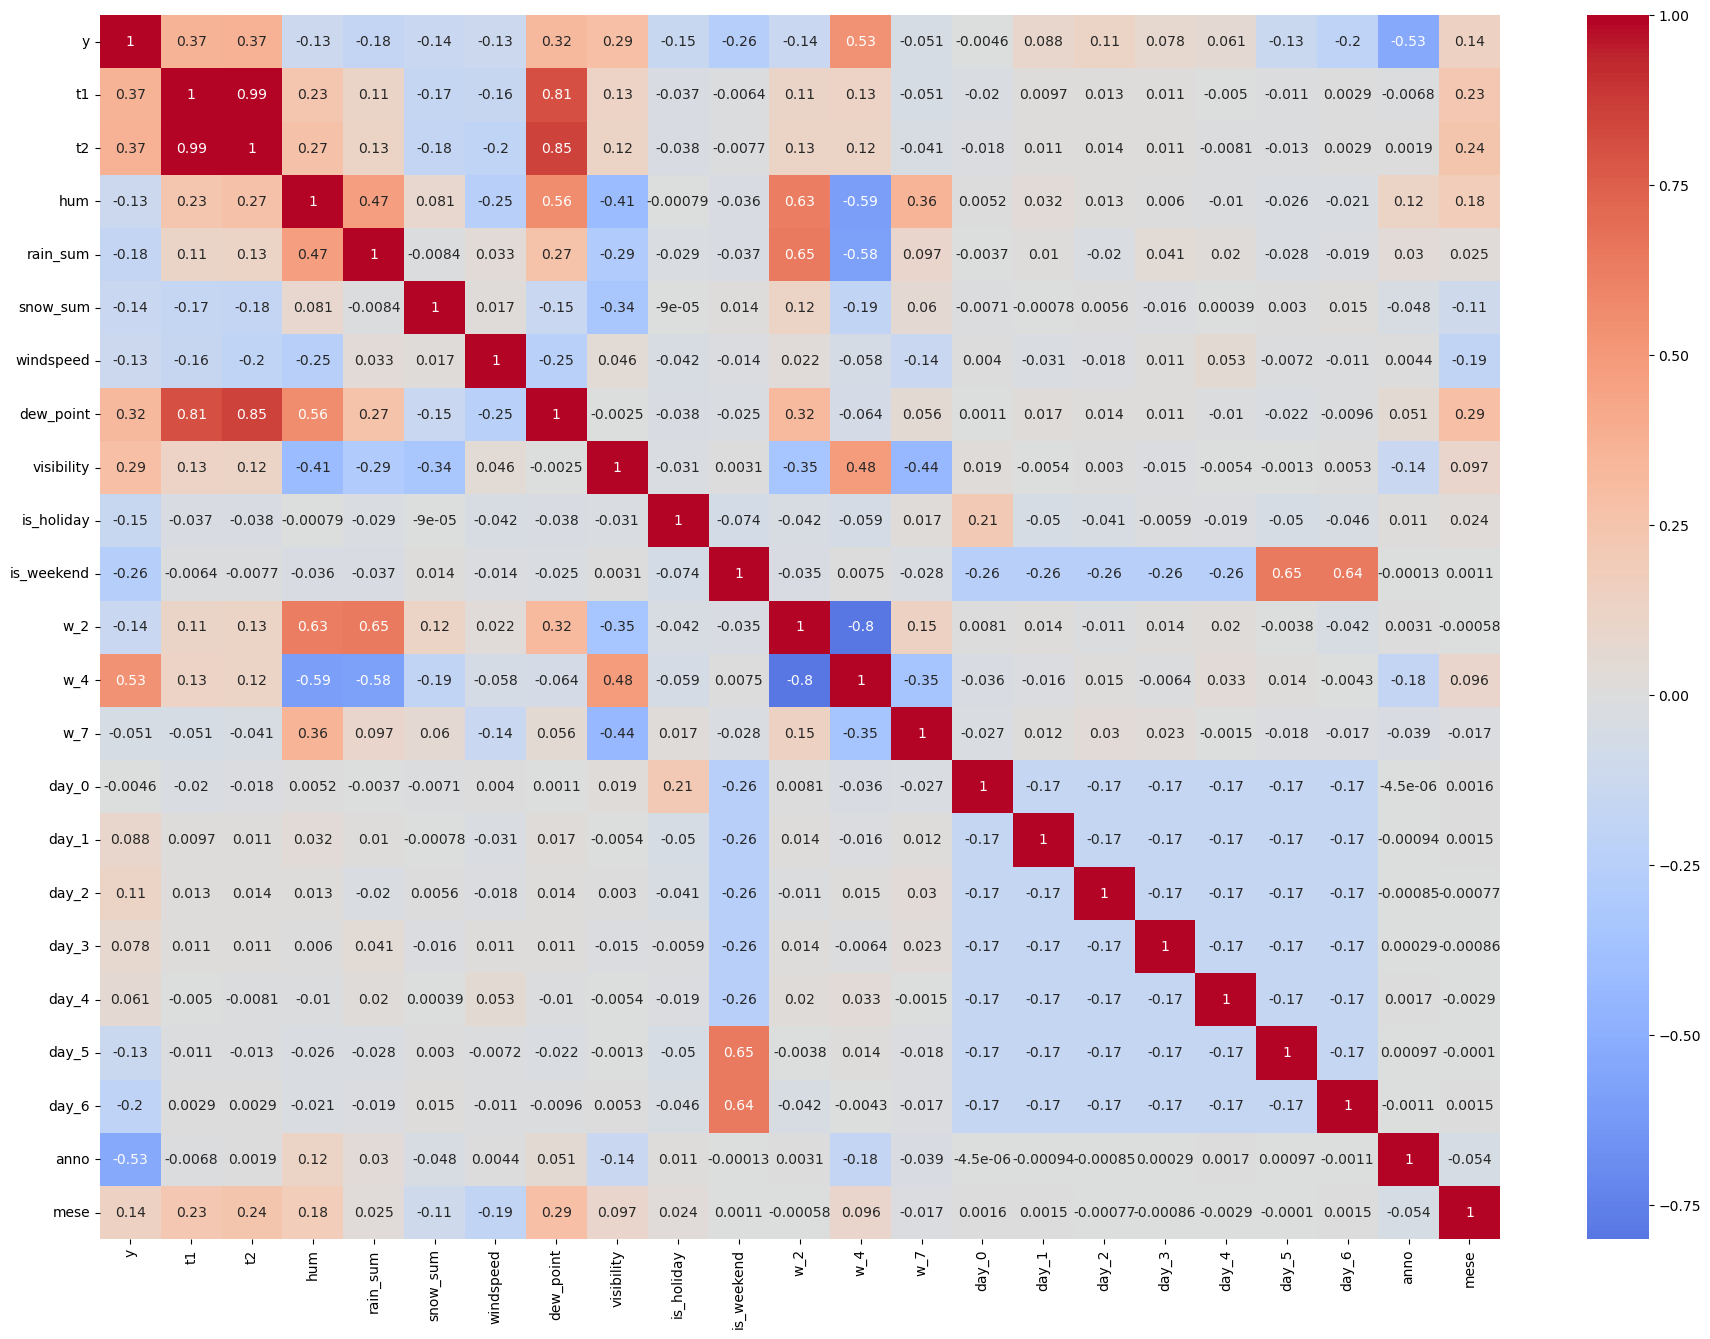

In [124]:
data_with_regressors.dropna(inplace=True)

data_with_regressors.head()

import seaborn as sns
import matplotlib.pyplot as plt


corr = data_with_regressors.corr()

# Imposta le dimensioni della figura
plt.figure(figsize=(25, 18))

# Disegna il plot di correlazione
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)

# Aggiusta gli spazi tra le subplots
plt.subplots_adjust(left=0.2, bottom=0.2)

# Mostra il plot
plt.show()

This code snippet showcases the preparation and evaluation stages for a forecasting model using Facebook's Prophet. Initially, it confirms the tail of the `data_with_regressors` DataFrame to ensure data integrity before moving on to the model instantiation. The hyperparameters for the model, such as prior scales and the number of Fourier series are tuned.

The dataset is then split into training and testing subsets based on dates, allowing for the assessment of the model's predictive power on unseen data. 

The Prophet models (`m` and `m2`) are then set up with specific seasonality modes and holiday dataframes. Various regressors are added to the m model to account for external influences on the target variable, each with a multiplicative effect, indicating that these factors have a proportional impact on the target variable.

After fitting the models to the training data, future dataframes are generated to predict the same length as the test set. The `add_regressor_to_future` utility function adds the regressors' future values to this dataframe.

Predictions are made on the futures dataframe, and verification dataframes (`verif` and `verif2`) are created to compare the forecasts with the actual data. 

**Finally, the code calculates correlation coefficients and error metrics, such as RMSE, MAE, and MAPE, to quantify the model's forecasting accuracy.** The results are printed out, comparing the performance of the models with and without meteorological data to determine the impact of weather on forecasting accuracy.

In [125]:

### calcolo la correlazione tra y_tansformed e le altre variabili

data_with_regressors.tail()

### MODELLO PROPHET The first step in fbprophet is to instantiate the model, it is there that you can set the prior scales for each component of your time-series, as well as the number of Fourier series to use to model the cyclic components. 
###A general rule is that larger prior scales and larger number of Fourier series will make the model more flexible, but at the potential cost of generalisation: i.e. the model might overfit, learning the noise (rather than the signal) in the training data, but giving poor results when applied to yet unseen data (the test data)... setting these hyperparameters can be more an art than a science ...

full_df=data_with_regressors

data_with_regressors=full_df

#data_train= data_with_regressors.iloc[:-30]# train fino all'1 maggio
data_train= data_with_regressors.iloc[:-15]# train fino al 15 Maggio

data_train.shape

#data_train.tail(100)

#data_test = data_with_regressors.iloc[-30:]#fino al 30 maggio 
data_test = data_with_regressors.iloc[-15:]#fino al 30 maggio

# resetta l'indice e trasformalo in una colonna
data_train = data_train.reset_index()
data_test = data_test.reset_index()

# rinomina la colonna dell'indice come "ds"
data_train = data_train.rename(columns={'datetime': 'ds'})
data_test = data_test.rename(columns={'datetime': 'ds'})

from prophet import Prophet
m = Prophet(holidays=holidays_df, holidays_prior_scale=0.55,changepoint_prior_scale=0.06,seasonality_mode='multiplicative')
m2= Prophet(holidays=holidays_df, holidays_prior_scale=0.55,changepoint_prior_scale=0.06,seasonality_mode='multiplicative')

# IPERPARAMETRI

m.add_regressor('t1', mode='multiplicative') # pred 0.5
m.add_regressor('t2', mode='multiplicative') # pred 0.5
m.add_regressor('dew_point',mode='multiplicative') # pred 0.5
m.add_regressor('visibility', mode='multiplicative') # pred 0.5
m.add_regressor('rain_sum', mode='multiplicative') # pred 0.5
m.add_regressor('snow_sum', mode='multiplicative') # pred 0.5
m.add_regressor('windspeed', mode='multiplicative') # pred 0.5
m.add_regressor('is_weekend', mode='multiplicative') # pred 0.5
m.add_regressor('is_holiday', mode='multiplicative') # pred 0.5


#m.add_regressor('w_8', mode='multiplicative') # pred 0.5
m.add_regressor('w_2', mode='multiplicative') # pred 0.5
#m.add_regressor('w_3', mode='multiplicative') # pred 0.5
m.add_regressor('w_7', mode='multiplicative') # pred 0.5
m.add_regressor('w_4', mode='multiplicative') # pred 0.5

m.add_regressor('day_0', mode='multiplicative') # pred 0.5
m.add_regressor('day_1', mode='multiplicative') # pred 0.5
m.add_regressor('day_2', mode='multiplicative') # pred 0.5
m.add_regressor('day_3', mode='multiplicative') # pred 0.5
m.add_regressor('day_4', mode='multiplicative') # pred 0.5
m.add_regressor('day_5', mode='multiplicative') # pred 0.5
m.add_regressor('day_6', mode='multiplicative') # pred 0.5

m.add_regressor('mese', mode='multiplicative') # pred 0.5

m.fit(data_train)
m2.fit(data_train)

future = m.make_future_dataframe(periods=len(data_test), freq='1D')
furture2=m2.make_future_dataframe(periods=len(data_test), freq='1D')
#future = m.make_future_dataframe(periods=len(data_train), freq='1D')
futures = utils.add_regressor_to_future(future, [t1,t2,wind,rain_sum,snow_sum,dew_point,visibility,w_2,w_4,w_7,day_0,day_1,day_2,day_3,day_4,day_5,day_6,is_weekend,is_holiday,mese])
#futures = utils.add_regressor_to_future(future, [t1, t2, hum, wind, w_code, dew_point, visibility, is_holiday, is_weekend])

#future.tail()

forecast = m.predict(futures)
forecast2 = m2.predict(futures)

verif = utils.make_verif(forecast, data_train, data_test)
verif2 = utils.make_verif(forecast2, data_train, data_test)

verif.loc[:, 'yhat'] = verif['yhat'].clip(lower=0)
verif.loc[:, 'yhat_lower'] = verif['yhat_lower'].clip(lower=0)

verif2.loc[:, 'yhat'] = verif2['yhat'].clip(lower=0)
verif2.loc[:, 'yhat_lower'] = verif2['yhat_lower'].clip(lower=0)

import numpy as np
from scipy import stats

# rimuove i valori NaN
verif = verif.dropna()

# rimuove i valori infiniti
verif = verif.replace([np.inf, -np.inf], np.nan).dropna()

# calcola la correlazione
r, _ = stats.pearsonr(verif['y'], verif['yhat'])
rho, _ = stats.spearmanr(verif['y'], verif['yhat'])

verif2 = verif2.dropna()
verif2 = verif2.replace([np.inf, -np.inf], np.nan).dropna()
r2, _ = stats.pearsonr(verif2['y'], verif2['yhat'])
rho2, _ = stats.spearmanr(verif2['y'], verif2['yhat'])

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Calcola l'RMSE, il MAE e MAPE tra le previsioni e i valori effettivi
rmse = np.sqrt(np.mean((verif['y'] - verif['yhat']) ** 2))
mae = np.mean(np.abs(verif['y'] - verif['yhat']))
mape = np.mean(np.abs((verif['y'] - verif['yhat']) / verif['y'])) * 100

rmse2 = np.sqrt(np.mean((verif2['y'] - verif2['yhat']) ** 2))
mae2 = np.mean(np.abs(verif2['y'] - verif2['yhat']))
mape2 = np.mean(np.abs((verif2['y'] - verif2['yhat']) / verif2['y'])) * 100

# Mostra i valori degli indici per il primo modello
print('risultati forecast con dati meteo')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R2: {r:.2f}')
print(f'r: {r:.2f}')
print(f'rho: {rho:.2f}')
print(f'MAPE: {mape:.2f}%')

# Mostra i valori degli indici per il secondo modello
print('risultati forecast senza dati meteo')
print(f'RMSE: {rmse2:.2f}')
print(f'MAE: {mae2:.2f}')
print(f'R2: {r2:.2f}')
print(f'r: {r2:.2f}')
print(f'rho: {rho2:.2f}')
print(f'MAPE: {mape2:.2f}%')

18:10:26 - cmdstanpy - INFO - Chain [1] start processing
18:10:31 - cmdstanpy - INFO - Chain [1] done processing
18:10:32 - cmdstanpy - INFO - Chain [1] start processing
18:10:33 - cmdstanpy - INFO - Chain [1] done processing


risultati forecast con dati meteo
RMSE: 20.75
MAE: 15.94
R2: 0.94
r: 0.94
rho: 0.95
MAPE: 14.98%
risultati forecast senza dati meteo
RMSE: 32.50
MAE: 24.38
R2: 0.85
r: 0.85
rho: 0.85
MAPE: 45.37%


# PART VI: Outcomes comparison

## The results indicate a clear difference between forecasting with and without the incorporation of meteorological data as regressors.

For the model that includes meteorological data:

- RMSE (Root Mean Square Error) is 20.75, indicating the standard deviation of the predictions from the actual values. A lower value suggests more accurate predictions.
- MAE (Mean Absolute Error) is 15.94, showing the average of the absolute differences between predictions and actual values, indicating smaller errors on average compared to the model without meteorological data.
- Both R² and r (Pearson's correlation coefficient) have a value of 0.94, suggesting that there is a strong positive correlation between predicted and actual values.
- rho (Spearman's rank correlation coefficient) is 0.95, indicating a strong monotonic correlation between the predicted and actual values, which aligns with Pearson's coefficient.
- MAPE (Mean Absolute Percentage Error) is 14.98%, meaning that on average, the predictions deviate from the actual value by 14.98%.

For the model without meteorological data:

- RMSE increases to 32.50, suggesting that the predictions are less precise.
- MAE rises to 24.38, indicating that the prediction errors are larger on average.
- Both R² and r drop to 0.85, showing a weaker positive correlation between predictions and actual values compared to the model with meteorological data.
- rho matches R² and r, confirming a weaker correlation.
- MAPE jumps to 45.37%, indicating that on average, the predictions are nearly twice as far off from the actual value as the model with meteorological data.

**In summary, the inclusion of meteorological data as regressors in the forecasting model significantly improves forecasting accuracy, as evidenced by the reduced MAPE and higher values of R² and rho, confirming a strong correlation between predicted and actual data. This confirms that meteorological data have a significant impact on the ability to predict the target value accurately.**

## TIME SERIES PLOTTING AND FUTHER RESULTS

This code allow us to visualize the results of time series forecasting using the Prophet model.

- Initially, the code plots the complete time series from 2013 to 2023 with the predictions overlaid, setting an appropriate title and displaying the plot.

- The section commented as "TIME SERIES FEBBRAIO" (February time series) is actually plotting a subset of the time series data, distinguishing between training and testing data points, and the predictions made with and without meteorological regressors.

- Lastly, the code generates a focused plot for the month of May (Forecasting di Maggio), displaying the observed values (Valori osservati) and the predicted values with and without meteorological regressors (Predicted with/without Meteo Regressors).

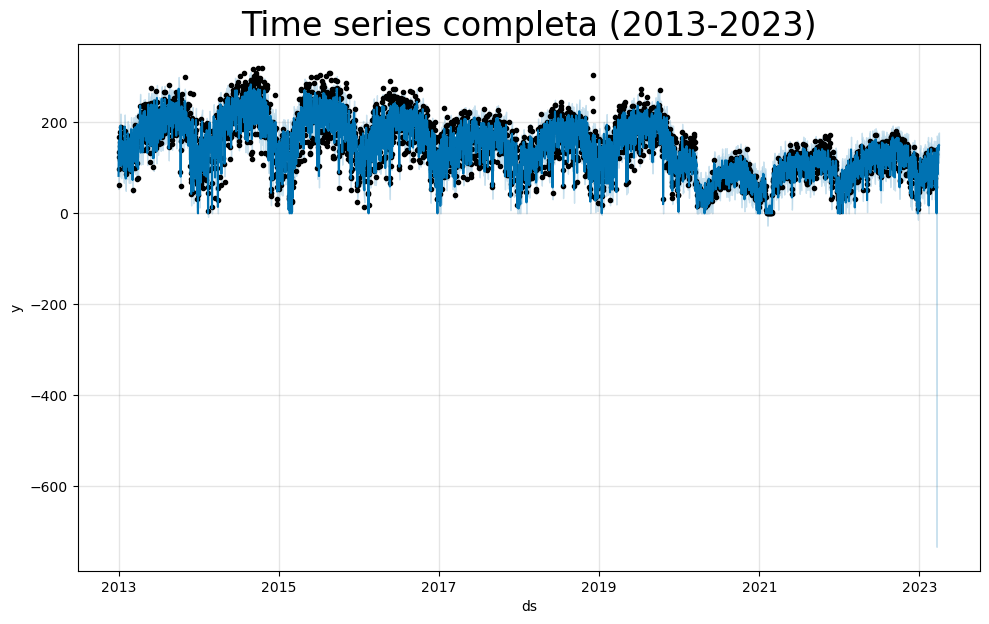

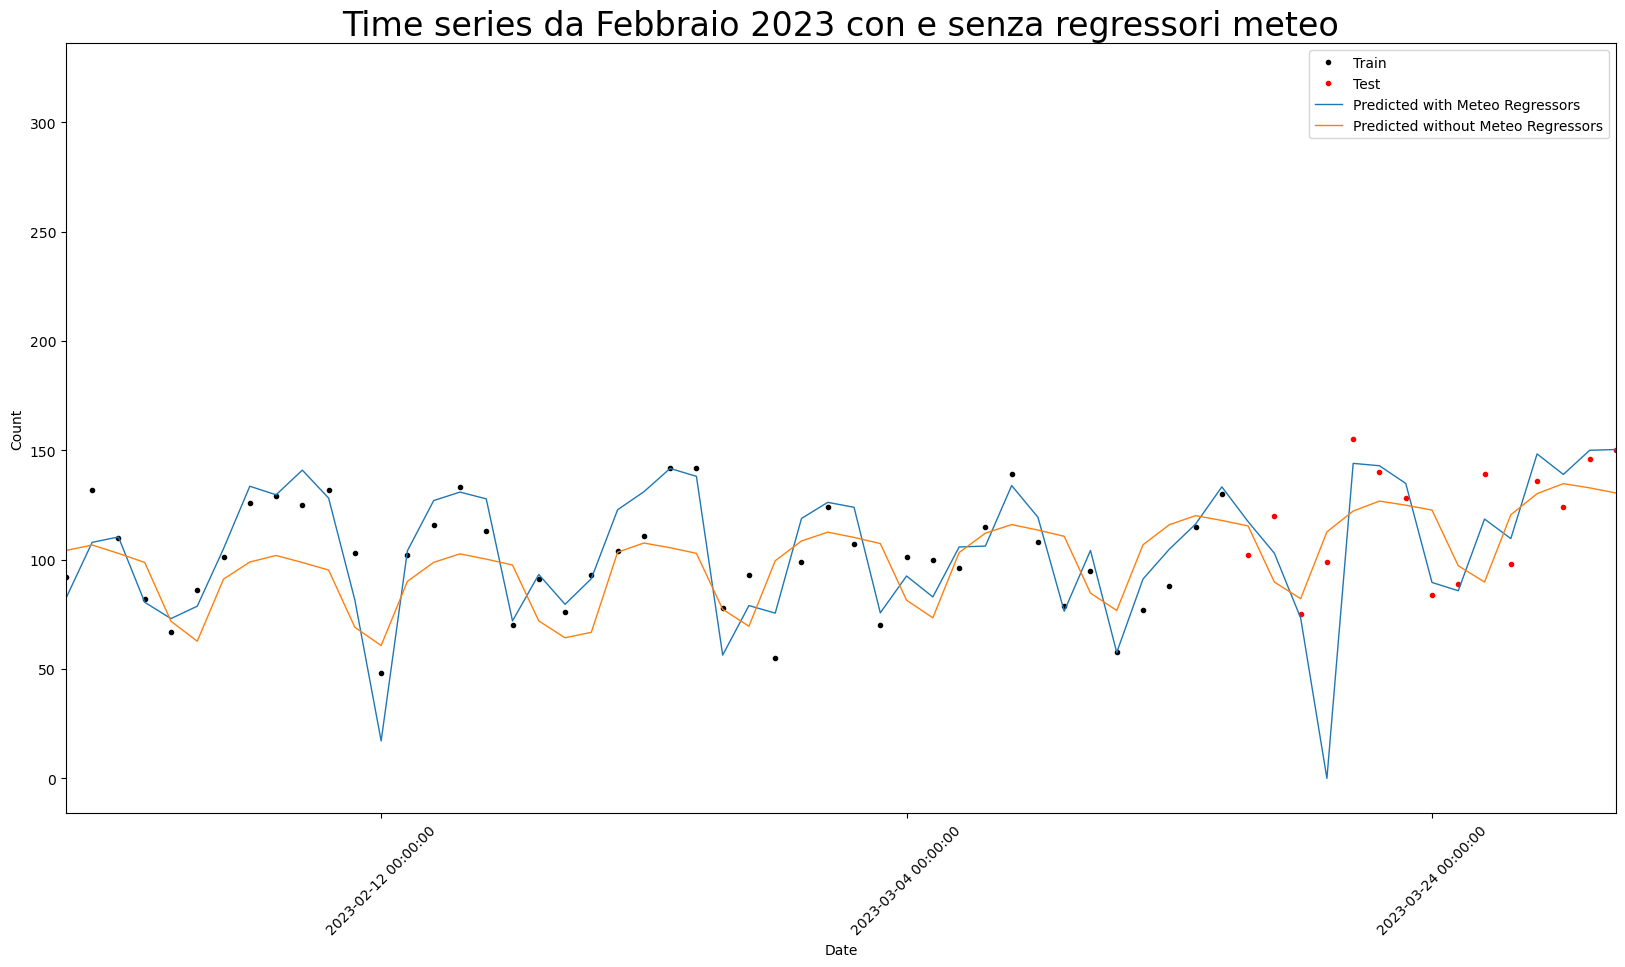

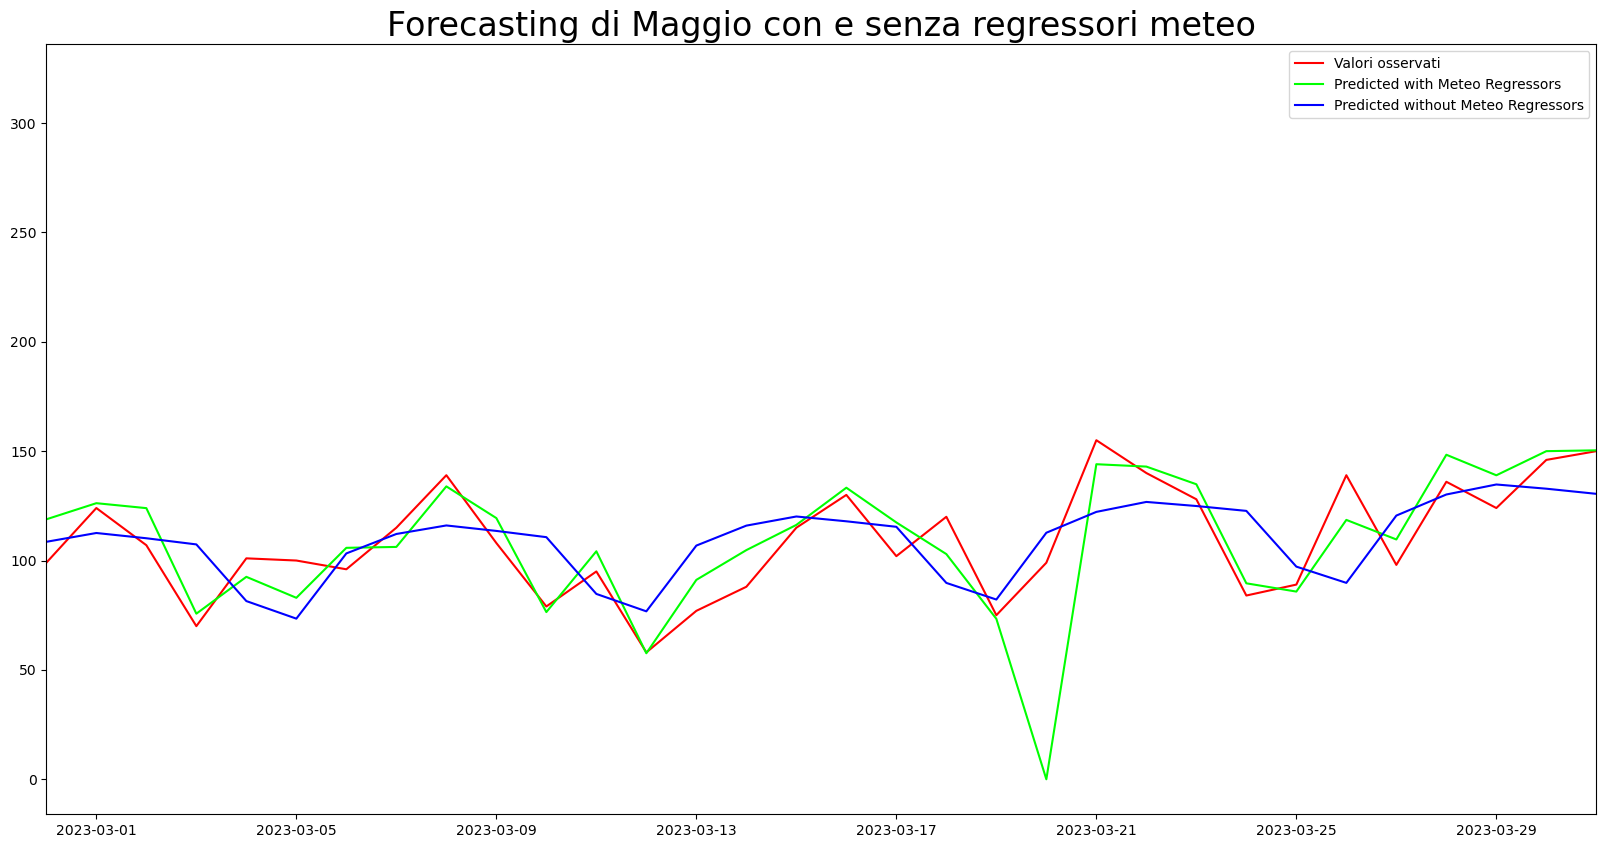

In [126]:
#-----------------------------------------
#verif.to_csv('verif2.csv')

import matplotlib.pyplot as plt

fig = m.plot(forecast)

#fig2= m2.plot(forecast2)

plt.title("Time series completa (2013-2023)", fontsize=24)

plt.show()


#TIME SERIES FEBBRAIO

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(data_train['ds'], data_train['y'], 'k.', label='Train')
ax.plot(data_test['ds'], data_test['y'], 'r.', label='Test')
ax.plot(verif['ds'], verif['yhat'], linestyle='-', linewidth=1, label='Predicted with Meteo Regressors')

ax.plot(verif2['ds'], verif2['yhat'], linestyle='-', linewidth=1, label='Predicted without Meteo Regressors')

ax.legend(loc='best')
ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.set_xticks(verif['ds'][::20])
ax.set_xticklabels(verif['ds'][::20], rotation=45)
last_year = verif['ds'].max().year
last_year_start = pd.to_datetime(f'{last_year}-01-31')
ax.set_xlim(last_year_start, verif['ds'].max())

ax.set_title("Time series da Febbraio 2023 con e senza regressori meteo", fontsize=24)

# Salva il plot come un'immagine
plt.savefig('time_series_comparison.png')  # Specifica il percorso e il nome del file

plt.show()


#forecast MAGGIO 

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

color1 = "#FF0000"  # Colore personalizzato per la prima linea (rosso)
color2 = "#00FF00"  # Colore personalizzato per la seconda linea (verde)
color3 = "#0000FF"  # Colore personalizzato per la terza linea (blu)

plt.plot(verif['ds'], verif['y'], label='Valori osservati', color=color1)
plt.plot(verif['ds'], verif['yhat'], label='Predicted with Meteo Regressors', color=color2)
#plt.plot(verif2['ds'], verif2['y'], label='Valori osservati 2')
plt.plot(verif2['ds'], verif2['yhat'], label='Predicted without Meteo Regressors', color=color3)

plt.legend()
plt.xlim([verif['ds'].max() - pd.DateOffset(months=1), verif['ds'].max()])

plt.title("Forecasting di Maggio con e senza regressori meteo", fontsize=24)

plt.savefig('forecast_comparison.png')  # Specifica il percorso e il nome del file

plt.show()

**The predictions made with meteorological data appear to follow the actual observed trend more closely than the predictions made without meteorological data, which is consistent with the previously discussed metrics indicating a more accurate forecast when incorporating meteorological regressors.** 

### Scatterplot and errors bar charts

This final block of code is dedicated to futher visualizing and comparing the forecasting performance of the two different Prophet models.

1. The first scatter plot (left) shows the relationship between the actual and predicted values where meteorological data are used. The blue scatter points indicate individual predictions, while the red regression line highlights the general trend of the predictions. The title and a bold label clearly indicate that meteorological data was used in this model.

2. The second scatter plot (right) shows the relationship without using meteorological data. The green scatter points and the purple regression line perform the same function as in the first plot but represent the model without meteorological regressors. It's labeled accordingly to distinguish from the meteorological data-inclusive model.


3. The final part of the code its dedicated to generating a bar chart comparing RMSE, MAE, and MAPE values for the two models.

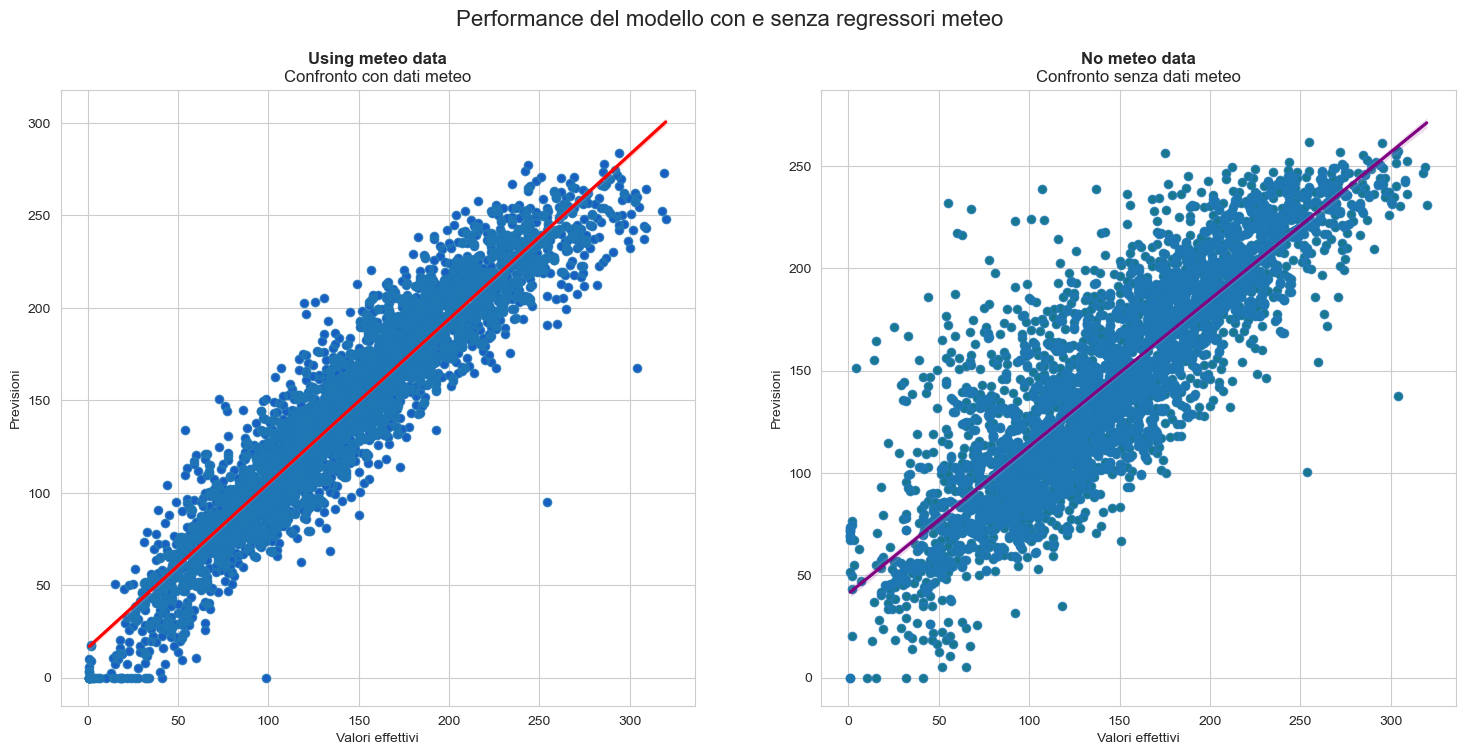

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


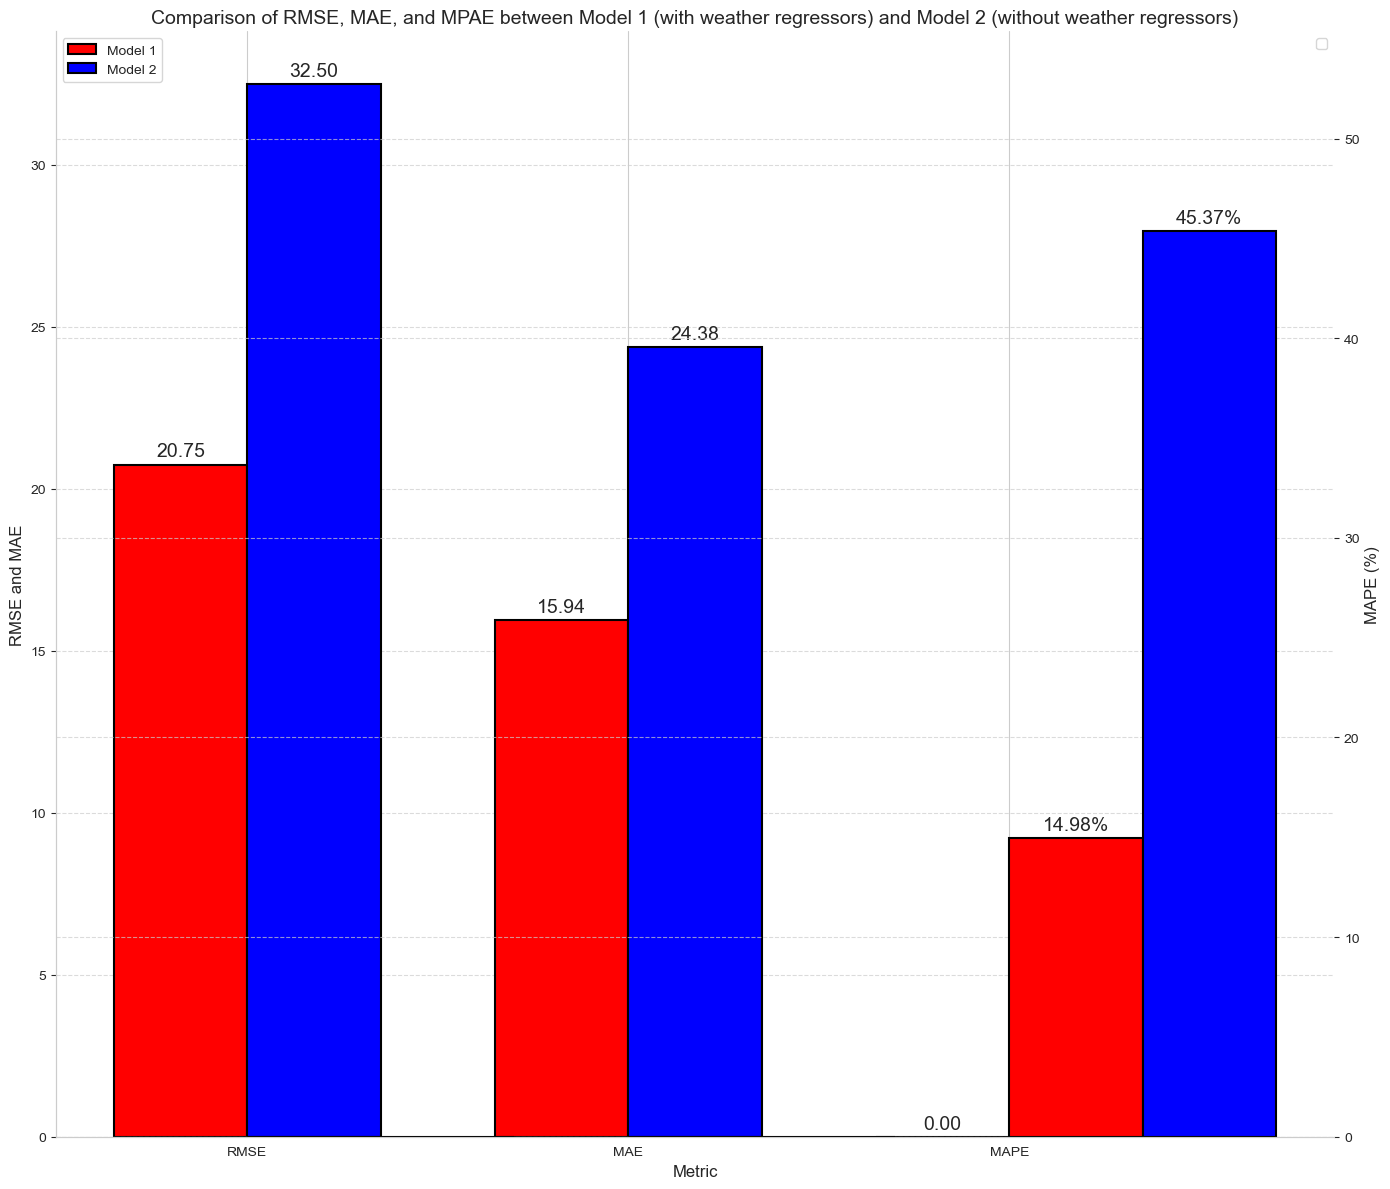

In [127]:
### SCATTERPLOT

import seaborn as sns
import matplotlib.pyplot as plt

# Imposta lo stile di Seaborn con la griglia di sfondo
sns.set_style("whitegrid")

# Crea una figura con due sottoplot affiancati
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Primo sottoplot: verif
sns.scatterplot(data=verif, x='y', y='yhat', color='blue', edgecolor='white', ax=axes[0])
sns.regplot(data=verif, x='y', y='yhat', line_kws={'color': 'red'}, ax=axes[0])
axes[0].set_xlabel('Valori effettivi')
axes[0].set_ylabel('Previsioni')
axes[0].set_title('Confronto con dati meteo')
axes[0].text(0.5, 1.05, 'Using meteo data', ha='center', va='center', transform=axes[0].transAxes, fontsize=12, fontweight='bold')

# Secondo sottoplot: verif2
sns.scatterplot(data=verif2, x='y', y='yhat', color='green', edgecolor='white', ax=axes[1])
sns.regplot(data=verif2, x='y', y='yhat', line_kws={'color': 'purple'}, ax=axes[1])
axes[1].set_xlabel('Valori effettivi')
axes[1].set_ylabel('Previsioni')
axes[1].set_title('Confronto senza dati meteo')
axes[1].text(0.5, 1.05, 'No meteo data', ha='center', va='center', transform=axes[1].transAxes, fontsize=12, fontweight='bold')

# Aggiungi un titolo al grafico
fig.suptitle('Performance del modello con e senza regressori meteo  ', fontsize=16)

# Aggiungi la griglia di sfondo
for ax in axes:
    ax.grid(True)

    
plt.savefig('scatterplot.png')  # Specifica il percorso e il nome del file
# Mostra il grafico
plt.show()


import matplotlib.pyplot as plt

# Valori calcolati
metrics_model1 = [rmse, mae]  # RMSE e MAE per il modello 1
metrics_model2 = [rmse2, mae2]  # RMSE e MAE per il modello 2
labels = ['RMSE', 'MAE']

import numpy as np
import matplotlib.pyplot as plt

# Dati dei due modelli
rmse_model1 = rmse
mae_model1 = mae
mpae_model1 = mape

rmse_model2 = rmse2
mae_model2 = mae2
mpae_model2 = mape2

# Etichette delle metriche
metric_labels = ['RMSE', 'MAE', 'MAPE']

# Dati dei due modelli
model1_values = [rmse_model1, mae_model1, 0]
model2_values = [rmse_model2, mae_model2, 0]
model1_mpae = mpae_model1
model2_mpae = mpae_model2

# Posizione delle barre
bar_positions = np.arange(len(metric_labels))

# Larghezza delle barre
bar_width = 0.35

# Creazione del grafico a barre
fig, ax1 = plt.subplots(figsize=(14, 12))

# Barre per RMSE e MAE
bar1 = ax1.bar(bar_positions, model1_values, bar_width, label='Model 1', color='red', edgecolor='black', linewidth=1.5)
bar2 = ax1.bar(bar_positions + bar_width, model2_values, bar_width, label='Model 2', color='blue', edgecolor='black', linewidth=1.5)

# Asse y sinistro per RMSE e MAE
ax1.set_xlabel('Metric', fontsize=12)
ax1.set_ylabel('RMSE and MAE', fontsize=12)
ax1.set_title('Comparison of RMSE, MAE, and MPAE between Model 1 (with weather regressors) and Model 2 (without weather regressors)', fontsize=14)
ax1.set_xticks(bar_positions + bar_width / 2)
ax1.set_xticklabels(metric_labels, fontsize=10)
ax1.legend(loc='upper left', fontsize=10)

# Creazione del secondo asse y per MPAE come percentuale
ax2 = ax1.twinx()
bar3 = ax2.bar(bar_positions + bar_width, [0, 0, model1_mpae], bar_width, label='', color='red', edgecolor='black', linewidth=1.5)
bar4 = ax2.bar(bar_positions + 2 * bar_width, [0, 0, model2_mpae], bar_width, label='', color='blue', edgecolor='black', linewidth=1.5)

# Asse y destro per MPAE come percentuale
ax2.set_ylabel('MAPE (%)', fontsize=12)
ax2.set_ylim([0, max(model1_mpae, model2_mpae) + 10])
ax2.legend(loc='upper right', fontsize=10)

# Rimozione dei bordi superiori e destri del grafico
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Stile delle griglie
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Aggiunta dei valori sopra le barre
def add_bar_values(bars):
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords='offset points',
                     ha='center', va='bottom', fontsize=14)

add_bar_values(bar1)
add_bar_values(bar2)

# Aggiunta dei valori sopra le barre del MPAE
def add_mape_values(bars):
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if i == 2:
            ax2.annotate(f'{height:.2f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3), textcoords='offset points',
                         ha='center', va='bottom', fontsize=14)

add_mape_values(bar3)
add_mape_values(bar4)

# Impostazione dello spazio tra le barre
fig.tight_layout()

plt.savefig('error_comparisons.png')  # Specifica il percorso e il nome del file

# Visualizzazione del grafico
plt.show()



**We see that the predictions made with meteorological data appear to have a tighter cluster around the regression line, indicating higher accuracy compared to the more dispersed points of the model without meteorological data.**